# **Index**
1. [Imports](#1.-Imports)
2. [Data Exploration](#2.-Data-Exploration)
3. [Dataset Split](#3.-Dataset-Split)
4. [Data Loading and Preprocessing](#4.-Data-Loading-and-Preprocessing)
   - 4.1 [Handling Missing Values](#4.1-Handling-Missing-Values)
   - 4.2. [Load images from URLs](#4.2-Load-images-from-URLs)
   - 4.3. [Image Normalization and Resizing](#4.3-Image-Normalization-and-Resizing)
5. [Data Augmentation](#5.-Data-Augmentation)
6. [Models](#6.-Models)
   - 6.1. [Saving models and their histories](#6.1-Saving-models-and-their-histories)
   - 6.2. [Loading models and their histories](#6.2-Loading-models-and-their-histories)
   - 6.3. [Model Custom](#6.3-Model-Custom)
   - 6.4. [Model Transfer](#6.4-Model-Transfer)
   - 6.5. [Model Transfer 2 Layers](#6.5-Model-Transfer-2-Layers)
   - 6.6. [Model Custom Mod](#6.6-Model-Custom-Mod)
   - 6.7. [Model A](#6.7-Model-A)
   - 6.8. [Model B](#6.6-Model-B)
7. [Model Evaluation](#7.-Model-Evaluation)
  - 7.1. [Evaluation Functions](#7.1-Evaluation-Functions)
  - 7.2. [Printing Performance Metrics](#7.2-Printing-Performance-Metrics)
  - 7.3. [Plotting Training History](#7.3-Plotting-Training-History)
      - 7.3.1 [Model Custom](#7.3.1-Model-Custom)
      - 7.3.2 [Model Transfer](#7.3.2-Model-Transfer)
      - 7.3.3 [Model Transfer 2 Layers](#7.3.3-Model-Transfer-2-Layers)
      - 7.3.4 [Model Custom Mod](#7.3.4-Model-Custom-Mod)
      - 7.3.5 [Model A](#7.3.5-Model-A)
      - 7.3.6 [Model B](#7.3.6-Model-B)
8. [Multi Input Model](#8.-Multi-Input-Model)
  - 8.1. [Preprocessing non Images Data](#8.1.-Preprocessing-non-Images-Data)
  - 8.2. [Builiding and Training the Multi Input Model](#8.2.-Builiding-and-Training-the-Multi-Input-Model)
9. [Model Comparisons](#9.-Model-Comparisons)
      

# 1. Imports

In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import random
import requests
import os
import re
import datetime
import tensorflow as tf
from math import ceil
from PIL import Image
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D, Activation, concatenate
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from keras.models import load_model
import pickle

# 2. Data Exploration

In [2]:
data = pd.read_csv("fitzpatrick17k.csv")

1) __"label"__: The diagnosed disease label. In this dataset, we have 114 different diseases. Each disease has a minimum of 53 associated images.
2) __"md5hash"__: Unique label for each row.
3) __"fitzpatrick_scale"__: This column represents a scale from 1 to 6 indicating skin color, as demonstrated in the image below. The values in this column were provided by "Scale AI". Some rows have a value of -1, presumably indicating instances that were not classified.
4) __"fitzpatrick_centaur"__: 
This column represents a scale from 1 to 6 indicating skin color, as demonstrated in the image below. The values in this column were provided by" Centaur Lab"s Some rows have a value of -1, presumably indicating instances that were not classified..
5) __"nine_parition_label"__: There are nine categories for classifying skin diseases, as shown in the image below.
6) __"three_partition_label"__: There are three, more general, categories for classifying skin diseases, as shown in the image below.
7) __"qc"__: Looks like some observations regarding the validity of the labels attributed.
8) __"url"__: Image url.
9) __"url_alpanum"__: URL in alphanumeric alphabet.

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Memory growth must be set before GPUs have been initialized

<div style="text-align:center;">
    <img src="./scale.png" alt="image_1" style="width:50%;">
</div>

In [5]:
# check the head of the dataset
data.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,0a94359e7eaacd7178e06b2823777789,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,a39ec3b1f22c08a421fa20535e037bba,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


In [6]:
data['label'].value_counts()

label
psoriasis                      653
squamous cell carcinoma        581
lichen planus                  491
basal cell carcinoma           468
allergic contact dermatitis    430
                              ... 
port wine stain                 59
erythema elevatum diutinum      55
pustular psoriasis              53
xanthomas                       53
pilomatricoma                   53
Name: count, Length: 114, dtype: int64

In [7]:
classes = np.unique(data['label'])
classes

array(['acanthosis nigricans', 'acne', 'acne vulgaris',
       'acquired autoimmune bullous diseaseherpes gestationis',
       'acrodermatitis enteropathica', 'actinic keratosis',
       'allergic contact dermatitis', 'aplasia cutis',
       'basal cell carcinoma', 'basal cell carcinoma morpheiform',
       'becker nevus', 'behcets disease', 'calcinosis cutis', 'cheilitis',
       'congenital nevus', 'dariers disease', 'dermatofibroma',
       'dermatomyositis', 'disseminated actinic porokeratosis',
       'drug eruption', 'drug induced pigmentary changes',
       'dyshidrotic eczema', 'eczema', 'ehlers danlos syndrome',
       'epidermal nevus', 'epidermolysis bullosa',
       'erythema annulare centrifigum', 'erythema elevatum diutinum',
       'erythema multiforme', 'erythema nodosum', 'factitial dermatitis',
       'fixed eruptions', 'folliculitis', 'fordyce spots',
       'granuloma annulare', 'granuloma pyogenic',
       'hailey hailey disease', 'halo nevus', 'hidradenitis',
    

In [8]:
# Overview of the columns
print("Columns in 'data':\n")
for column in data.columns.tolist():
    print(column)

Columns in 'data':

md5hash
fitzpatrick_scale
fitzpatrick_centaur
label
nine_partition_label
three_partition_label
qc
url
url_alphanum


In [9]:
# Overview of the number of rows
print(f"Number of rows in 'data': {data.shape[0]}")

Number of rows in 'data': 16577


In [10]:
# Verifying if the URL is functioning properly
data["url"][0]

'https://www.dermaamin.com/site/images/clinical-pic/m/minocycline-pigmentation/minocycline-pigmentation1.jpg'

In [11]:
# Looking at the target variable ("label")
data["label"].value_counts()

label
psoriasis                      653
squamous cell carcinoma        581
lichen planus                  491
basal cell carcinoma           468
allergic contact dermatitis    430
                              ... 
port wine stain                 59
erythema elevatum diutinum      55
pustular psoriasis              53
xanthomas                       53
pilomatricoma                   53
Name: count, Length: 114, dtype: int64

In [12]:
number_labels = len(data["label"].value_counts().tolist())
print(f"Number of unique labels: {number_labels}")

Number of unique labels: 114


In [13]:
# Taking a look at the "md5hash" column
unique_values_md5hash = len(data["md5hash"].value_counts().tolist())
print(f"Unique values in 'md5hash' column: {unique_values_md5hash}")

Unique values in 'md5hash' column: 16577


In [14]:
# Taking a look at the "fitzpatrick_scale" column
data["fitzpatrick_scale"].value_counts()

fitzpatrick_scale
 2    4808
 3    3308
 1    2947
 4    2781
 5    1533
 6     635
-1     565
Name: count, dtype: int64

In [15]:
# Taking a look at the "three_partition_label" column
data["three_partition_label"].value_counts()

three_partition_label
non-neoplastic    12080
malignant          2263
benign             2234
Name: count, dtype: int64

In [16]:
# Taking a look at the "nine_partition_label" column
data["nine_partition_label"].value_counts()

nine_partition_label
inflammatory                    10886
malignant epidermal              1352
genodermatoses                   1194
benign dermal                    1067
benign epidermal                  931
malignant melanoma                573
benign melanocyte                 236
malignant cutaneous lymphoma      182
malignant dermal                  156
Name: count, dtype: int64

In [17]:
# Taking a look at the partition columns relationship
data.groupby("three_partition_label")["nine_partition_label"].value_counts()

three_partition_label  nine_partition_label        
benign                 benign dermal                    1067
                       benign epidermal                  931
                       benign melanocyte                 236
malignant              malignant epidermal              1352
                       malignant melanoma                573
                       malignant cutaneous lymphoma      182
                       malignant dermal                  156
non-neoplastic         inflammatory                    10886
                       genodermatoses                   1194
Name: count, dtype: int64

In [18]:
# Taking a look at the "fitzpatrick_centaur" column
data["fitzpatrick_centaur"].value_counts()

fitzpatrick_centaur
 1    5561
 2    3180
 3    2934
 4    1974
 5    1293
-1    1073
 6     562
Name: count, dtype: int64

In [19]:
# Taking a look at the "qc" column
data["qc"].value_counts()

qc
1 Diagnostic          348
5 Potentially          97
2 Characteristic       32
3 Wrongly labelled     17
4 Other                10
Name: count, dtype: int64

In [20]:
total_observations = len(data)
nan_info_list = []

for column in data.columns:
    nan_count = data[column].isna().sum()
    nan_percentage = (nan_count / total_observations) * 100
    nan_info_list.append({'Column Name': column,
                          'NaN Count': nan_count,
                          'Percentage of NaNs': f"{nan_percentage:.2f}%",
                          'Total Observations': total_observations})

nan_info = pd.DataFrame(nan_info_list)

print(nan_info)

             Column Name  NaN Count Percentage of NaNs  Total Observations
0                md5hash          0              0.00%               16577
1      fitzpatrick_scale          0              0.00%               16577
2    fitzpatrick_centaur          0              0.00%               16577
3                  label          0              0.00%               16577
4   nine_partition_label          0              0.00%               16577
5  three_partition_label          0              0.00%               16577
6                     qc      16073             96.96%               16577
7                    url         41              0.25%               16577
8           url_alphanum          0              0.00%               16577


**An MD5 hash is a widely used cryptographic hash function that produces a 32-character hexadecimal number, typically used for ensuring data integrity**

**While important for data management and integrity checking, MD5 hashes usually don't carry meaningful information for predictive modeling or statistical analysis, so we will drop the column**

In [21]:
data.drop('md5hash', axis=1, inplace=True)

# 3. Dataset Split

**Using 70% training, 15% validation, and 15% test sets.**

**Also applying stratified splitting, so we can mitigate biases introduced by class imbalances.**

Setting our target variable 'label' aside

In [22]:
X = data.drop('label', axis=1)
y = data['label']

First, we split the data into training and a temporary set (combining validation and test)

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Now we split the temporary set into validation and test sets

In [24]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

Printing the number of samples in each set

In [25]:
print(f"Training Set Length: {len(X_train)}")
print(f"Validation Set Length: {len(X_val)}")
print(f"Test Set Length: {len(X_test)}")

Training Set Length: 11603
Validation Set Length: 2487
Test Set Length: 2487


In [26]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

label
psoriasis                      457
squamous cell carcinoma        407
lichen planus                  344
basal cell carcinoma           328
allergic contact dermatitis    301
                              ... 
paronychia                      41
erythema elevatum diutinum      39
xanthomas                       37
pustular psoriasis              37
pilomatricoma                   37
Name: count, Length: 114, dtype: int64
label
psoriasis                        98
squamous cell carcinoma          87
lichen planus                    73
basal cell carcinoma             70
allergic contact dermatitis      64
                                 ..
langerhans cell histiocytosis     9
xanthomas                         8
erythema elevatum diutinum        8
pustular psoriasis                8
pilomatricoma                     8
Name: count, Length: 114, dtype: int64
label
psoriasis                      98
squamous cell carcinoma        87
lichen planus                  74
basal cell carcinoma 

# 4. Data Loading and Preprocessing

### 4.1 Handling Missing Values

**As seen above, we have missing values for columns "qc" & "url", lets handle them here**

First for "qc", lets assume that NaN values indicate 'No Issue' with the observations regarding the label

In [27]:
# Fill "qc" column NaN values with 'No Issue' for all dataset splits
X_train['qc'] = X_train['qc'].fillna('Normal')
X_val['qc'] = X_val['qc'].fillna('Normal')
X_test['qc'] = X_test['qc'].fillna('Normal')

Finally for "url", since there's no practical way to fill in missing image URLs, the most straightforward approach is to drop those rows. 

Also, these rows only constitute 0.25% of the dataset, so dropping them should have a minimal impact.

In [28]:
# Drop rows from the training set where 'url' is NaN
X_train = X_train.dropna(subset=['url'])
y_train = y_train.loc[X_train.index]

# Drop rows from the validation set where 'url' is NaN
X_val = X_val.dropna(subset=['url'])
y_val = y_val.loc[X_val.index]

# Drop rows from the test set where 'url' is NaN
X_test = X_test.dropna(subset=['url'])
y_test = y_test.loc[X_test.index]

Now lets just check again if all the NaNs were treated in all the dataset splits

In [29]:
# Checking for NaNs in X_train
nan_in_train = X_train.isna().sum()
nan_in_val = X_val.isna().sum()
nan_in_test = X_test.isna().sum()

# Print the summaries
print("NaNs in Training Set:\n\n", nan_in_train)
print("\nNaNs in Validation Set:\n\n", nan_in_val)
print("\nNaNs in Test Set:\n\n", nan_in_test)

NaNs in Training Set:

 fitzpatrick_scale        0
fitzpatrick_centaur      0
nine_partition_label     0
three_partition_label    0
qc                       0
url                      0
url_alphanum             0
dtype: int64

NaNs in Validation Set:

 fitzpatrick_scale        0
fitzpatrick_centaur      0
nine_partition_label     0
three_partition_label    0
qc                       0
url                      0
url_alphanum             0
dtype: int64

NaNs in Test Set:

 fitzpatrick_scale        0
fitzpatrick_centaur      0
nine_partition_label     0
three_partition_label    0
qc                       0
url                      0
url_alphanum             0
dtype: int64


### 4.2 Load images from URLs

**We're preparing an image loading function for use with a Data Generator approach. This method is chosen over loading all images into memory due to its efficiency with large datasets.**

**Using a Data Generator, like Keras' ImageDataGenerator, allows for progressive image loading. This is ideal for handling large datasets that may not fit into system memory. It also supports real-time data augmentation and preprocessing, enhancing model training and performance.**

ref: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

In [30]:
# def download_images(data, dataset_name):
#     base_dir = os.getcwd()
#     images_dir = os.path.join(base_dir, 'images', dataset_name)
#     errors = 0
#     success = 0
    
#     headers = {
#         'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:104.0) Gecko/20100101 Firefox/104.0'
#     }
    
#     for index, row in data.iterrows():
#         # Folder path based on class label
#         folder_path = os.path.join(images_dir, str(row['label']))
#         os.makedirs(folder_path, exist_ok=True)
        
#         # Define image path
#         img_name = f"{index}.jpg"
#         img_path = os.path.join(folder_path, img_name)
        
#         # Print status
#         print(f"Downloading image {index+1}/{len(data)}")
        
#         try:
#             # Try to download and save image
#             response = requests.get(row['url'], headers=headers, timeout=10)
#             response.raise_for_status()
#             with open(img_path, 'wb') as f:
#                 for chunk in response.iter_content(8192):
#                     f.write(chunk)
#             success += 1
#             print(f"Image {index+1}/{len(data)} downloaded successfully.")
            
#         except requests.exceptions.RequestException as e:
#             errors += 1
#             print(f"Error downloading image {index+1}: {e}")
    
#     # Print final status
#     print(f"Downloaded {success} images with {errors} errors.")

In [31]:
# # Joining X with label so we can save images in the correct subfolders. Resetting index as well so we know the actual progress of the download (1/x, 2/x, 3/x...)
# #train_df = X_train.join(y_train.rename('label')).reset_index(drop=True)
# val_df = X_val.join(y_val.rename('label')).reset_index(drop=True)
# test_df = X_test.join(y_test.rename('label')).reset_index(drop=True)

# # Download the images for each dataset
# #download_images(train_df, 'train')
# download_images(val_df, 'val')
# download_images(test_df, 'test')

### 4.3 Image Normalization and Resizing

**This section's focus is to establish the optimal resizing and normalization strategies. The actual resizing & normalization of the images will be integrated into the model implementation phase, where these preprocessing steps will occur dynamically.**

For the image resolution, lets select a subset and try to identify current images' most common default resolution.

In [32]:
def get_image_resolution(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        return img.size  # (width, height)
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return None

# Sampling a small number of URLs from each split
sample_size = 30
train_sample = random.sample(list(X_train['url']), sample_size)
val_sample = random.sample(list(X_val['url']), sample_size)
test_sample = random.sample(list(X_test['url']), sample_size)

# Resolutions for the sampled images
train_resolutions = [get_image_resolution(url) for url in train_sample]
val_resolutions = [get_image_resolution(url) for url in val_sample]
test_resolutions = [get_image_resolution(url) for url in test_sample]

# Combining the resolution data
all_resolutions = train_resolutions + val_resolutions + test_resolutions

Average Width: 508.0, Average Height: 461.3
Median Width: 457.5, Median Height: 387.0
Most Common Width: 485, Most Common Height: 364


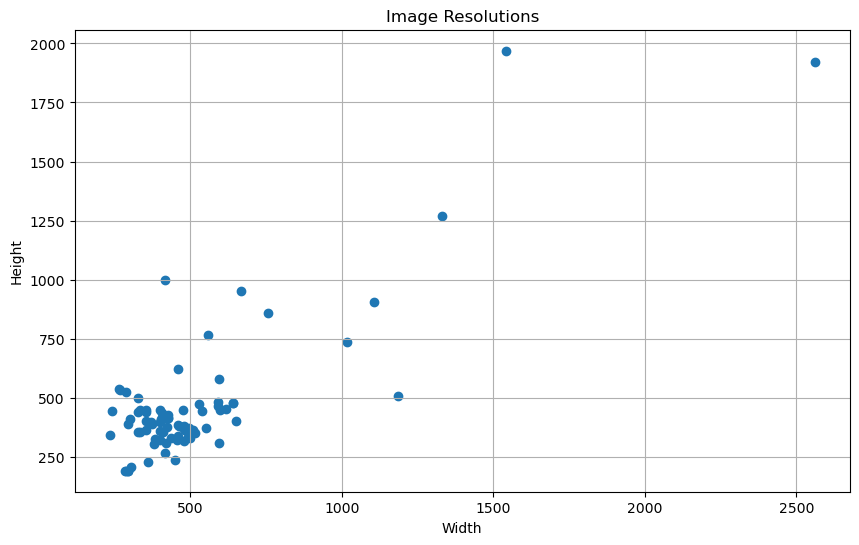

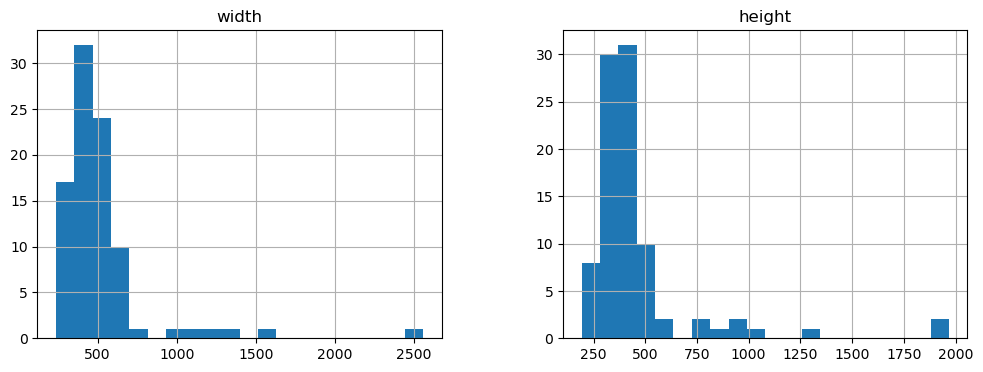

In [33]:
# Fetching 'width' and 'height' of each sampled resolution
resolutions_df = pd.DataFrame(all_resolutions, columns=['width', 'height'])

avg_width = resolutions_df['width'].mean()
avg_height = resolutions_df['height'].mean()
median_width = resolutions_df['width'].median()
median_height = resolutions_df['height'].median()
mode_width = resolutions_df['width'].mode()[0]
mode_height = resolutions_df['height'].mode()[0]

print(f"Average Width: {avg_width}, Average Height: {avg_height}")
print(f"Median Width: {median_width}, Median Height: {median_height}")
print(f"Most Common Width: {mode_width}, Most Common Height: {mode_height}")

# Visualizations
plt.figure(figsize=(10, 6))
plt.scatter(resolutions_df['width'], resolutions_df['height'])
plt.title('Image Resolutions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True)
plt.show()

# Histograms of widths and heights
resolutions_df.hist(column=['width', 'height'], bins=20, layout=(1, 2), figsize=(12, 4))
plt.show()

Based on the images, a target size of 256x256 pixels should be a good balance. It is a common dimension for many CNN models and would accommodate most of the images without substantial downscaling. This size is large enough to potentially capture necessary details for disease classification, yet small enough to keep the computational load reasonable.

To preserve the aspect ratio of the images, to prevent distortion, we can either:

- Resize the images so that the shorter side is 256 pixels and then crop the central part to get a 256x256 image.
- Resize the images so that the longer side is 256 pixels and then pad the shorter side to maintain the aspect ratio.

We will test both approaches during the model development phase.

As for normalization, we will be using a [0, 1] range. This scaling method is widely adopted because it ensures that our model trains more efficiently. By scaling the pixel values to this range, we help the neural network in handling the input data within a consistent scale, which can improve gradient flow during backpropagation and generally leads to faster convergence. 

# 5. Data Augmentation

Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. 

The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In [34]:
def center_crop(image):
    # We want to crop the center of the image to 224x224
    target_size = (224, 224)
    image_shape = tf.shape(image)
    # By finding the difference of the image's height and width to target size and dividing it by 2, we can ensure that the crop is centered
    offset_height = (image_shape[0] - target_size[0]) // 2
    offset_width = (image_shape[1] - target_size[1]) // 2
    
    # Performing the central crop
    center_cropped_image = tf.image.crop_to_bounding_box(
        image, offset_height, offset_width, target_size[0], target_size[1]
    )
    
    return center_cropped_image

In [35]:
# Creating an ImageDataGenerator with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    preprocessing_function=center_crop
)

In [36]:
# Creating an ImageDataGenerator with augmentation for training
variant_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20, 
    fill_mode='nearest',
    preprocessing_function=center_crop
)

The purpose of the validation and test sets is to evaluate the model's performance on data that represents real-world scenarios. Augmenting these datasets might introduce artificial variations that don't reflect actual conditions.

In [37]:
# Validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
# Defining each image dir
base_dir = os.getcwd()
train_dir = os.path.join(base_dir, 'images', 'train')
val_dir = os.path.join(base_dir, 'images', 'val')
test_dir = os.path.join(base_dir, 'images', 'test')

# Augmenting training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
)

train_generator_mod = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=100 # Higher batch size
)

train_generator_variant = variant_train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=100
)

# Validation generator (no augmentation)
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Test generator (no augmentation)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 11561 images belonging to 114 classes.
Found 11561 images belonging to 114 classes.
Found 11561 images belonging to 114 classes.
Found 2483 images belonging to 114 classes.
Found 2480 images belonging to 114 classes.


# 6. Models

### 6.1 Saving models and their histories

In [39]:
def save_model_history(model, model_history, model_name):
    # Create a directory with the model name if it doesn't exist
    if not os.path.exists(model_name):
        os.makedirs(model_name)

    # Save the model (in .h5 format) inside the created directory
    model.save(os.path.join(model_name, f'{model_name}.h5'))

    # Save the training history inside the created directory with pickle
    with open(os.path.join(model_name, f'{model_name}_history.pkl'), 'wb') as file:
        pickle.dump(model_history.history, file)

### 6.2 Loading models and their histories

In [40]:
def load_model_history(model_directory):
    # Check if the specified directory exists
    if not os.path.exists(model_directory):
        raise FileNotFoundError(f"Directory '{model_directory}' not found.")

    # In case of any problems loading the .h5 model, there is an alternative SavedModel type to access that just remove the .h5 from the string below
    model_path = os.path.join(model_directory, f'{os.path.basename(model_directory)}.h5')
    loaded_model = load_model(model_path)

    # Load the training history from the pickled file
    history_path = os.path.join(model_directory, f'{os.path.basename(model_directory)}_history.pkl')
    with open(history_path, 'rb') as file:
        loaded_history = pickle.load(file)
    return loaded_model, loaded_history

### 6.3 Model Custom

**Layers:**
- First, we use **Convolutional (Conv) Layers**. This layer applies various filters to the input, creating feature maps that represent the presence of specific features. They are essential for processing and learning features from image data and they are usually present in the initial and middle parts of a CNN.

- Then, we use **Dense (Fully Connected) Layers**. The output from the convolutional and pooling layers represent high-level features of the input image. The purpose of the Fully Connected layer is to use these features for classifying the input image into various classes based on the training dataset. <br>We have a Flatten layer before the Dense layers to convert the 2D feature maps into a 1D vector.

**Implementation Notes:**
- After each Conv Layer, we also use a **MaxPooling** to **reduce the dimensionality**. MaxPooling extracts the dominant features (like edges, textures, etc.) while discarding the non-dominant ones. By taking the maximum value over the window, it keeps only the most present features in each patch of the feature map.<br>
We initially use a 2x2 window.

- Following the "The LeNet Architecture" best practices, we also use **'relu'** as our **activation function**, since they **introduce non-linearity** into the model, which is crucial for learning complex patterns in the data.<br> For the last layer, since it is a Fully Connected layer, we use a softmax activation function with a number of units equal to the number of classes (the softmax function outputs a probability distribution over the classes). 

- As you go deeper into the network, the filters begin to have a larger and larger receptive field, which means that they are able to consider information from a larger area of the original input volume, so we increase the number of filters in successive convolutional layers.

- Since we are classifying between 114 classes, the problem is complex. For that reason, we start with 4 Conv Layers. We will adjust the number of layers based on the model's performance during training and validation.

- We use **Dropout** to prevent overfitting. During training, Dropout randomly "drops" a fraction of the neurons in the layer to which it is applied. This prevents neurons from becoming overly dependent on the specific contributions of other neurons, encouraging them to learn more robust and independent features.

- Finally, for the model compilation, we are using standard choices (which we will adjust in model evaluation, if needed).

In [41]:
model_custom, history_custom = load_model_history(r'models/model_custom')

model_custom_w_cw, history_custom_w_cw = load_model_history(r'models/model_custom_w_cw')

__BUILDING__

In [42]:
def build_custom_model(mod=None):
    """
    Constructs a custom convolutional neural network model with optional dropout and additional layers.

    Parameters:
    - mod (list, optional): A list of keras layers to insert after the last dense layer before the output layer. 
      Defaults to a single Dropout layer with a 0.5 dropout rate if no argument is provided.

    Returns:
    - Sequential: A Keras model instance configured with the specified layers.
    """
    # Setting a default Dropout layer if no custom layers are provided
    if mod is None:
        mod = [Dropout(0.5)]

    # Defining the model architecture
    model_custom = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        *mod, # Unpacking additional modifications, if any
        Dense(114, activation='softmax')
    ])

    return model_custom

# Create models using the function
model_custom = build_custom_model()
model_custom_w_cw = build_custom_model()

# Compile the models with the same optimizer and loss function
model_custom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_custom_w_cw.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

__CALLBACKS__

Callbacks in Keras are optional but highly recommended tools that can help you monitor and optimize your model during training. They can help you perform certain actions at various stages of the training process, such as at the end of an epoch or after a certain number of iterations or batches.

Model checkpointing — Saving the current weights of the model at different points during training.

Early stopping — Interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training).

In [43]:
callbacks_list_custom = [
    ModelCheckpoint(
        'model_custom_best.keras', 
        monitor='val_loss', 
        save_best_only=True, 
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        verbose=1,
        restore_best_weights=True
    ) 
]

__Handling Class Imbalance__

To address imbalance in our dataset's class distribution. Utilizing the **compute_class_weight function from scikit-learn** enables us to determine appropriate weights for each class. This method is essential to ensure that classes with fewer samples receive increased attention during our machine learning model's training process.

In [44]:
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(classes),
#     y=y_train
# )
# 
# class_weights_dict = {i : class_weights[i] for i,label in enumerate(classes)}

__TRAINING__

(without classweights)

In [45]:
# history_custom = model_custom.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=100,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size,
#     callbacks=callbacks_list_custom,
# )

(with classweights)

In [46]:
# history_custom_w_cw = model_custom_w_cw.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=100,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size,
#     callbacks=callbacks_list_custom,
#     class_weight=class_weights_dict
# )

__SAVING__

In [47]:
# save_model_history(model_custom, model_custom, 'model_custom')

In [48]:
# save_model_history(model_custom_w_cw, history_custom_w_cw, 'model_custom_w_cw')

### 6.4 Model Transfer

__Building a Pre-Trained CNN (without last 3 fully connected layers)__

In this section, we implement a transfer learning model based on the **VGG-16 architecture pre-trained on the ImageNet dataset**. The pre-trained VGG-16 model is utilized as a feature extractor, with the top fully connected layer replaced to suit our specific task.

**Transfer learning offers several advantages for our task:**
- **Quicker Training:** Leveraging a pre-trained model like VGG-16 significantly reduces training time compared to training custom models from scratch.
- **Improved Performance & Better Generalization:** We can benefit from the knowledge encoded in the pre-trained weights, leading to better performance & generalization.<br><br>

The **architecture** starts with the VGG-16 convolutional base, which extracts hierarchical features from the input images.
We replace the original fully connected layer with a sequence of layers tailored to our classification task:
- A fully connected layer with 256 units.
- A ReLU activation layer to introduce non-linearity.
- A dropout layer with a 40% dropout rate to prevent overfitting.
- A final fully connected layer with the number of predicted categories.
- A softmax layer for multi-class classification, producing a probability distribution over the classes.

In [49]:
model_transfer, history_transfer = load_model_history(r'models/model_transfer')

model_transfer_w_cw, history_transfer_w_cw = load_model_history(r'models/model_transfer_w_cw')

__BUILDING__

In [50]:
def build_transfer_model():
    """
    Builds a transfer learning model using the VGG16 architecture.

    This function initializes a VGG16 model pre-trained on the ImageNet dataset, excludes its
    top fully connected layers, and appends custom top layers tailored for a specific classification
    task with 114 classes. The pre-trained layers are frozen to retain learned features.

    Returns:
        Sequential: A Keras model instance with the VGG16 base and custom top layers.
    """
    # Initialize the VGG16 model with weights pre-trained on ImageNet, without the fully connected layers at the top
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the weights of the pre-trained layers
    base_model.trainable = False

    # Add custom top layers for our classification task on top of the base model
    model_transfer = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(114, activation='softmax')
    ])

    return model_transfer

# Build models using the defined function
model_transfer = build_transfer_model()
model_transfer_w_cw= build_transfer_model()

# Compile the models
model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_transfer_w_cw.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

__CALLBACKS__

In [51]:
# callbacks_list_transfer = [
#     ModelCheckpoint(
#         'model_transfer_best.keras',
#         monitor='val_loss', 
#         save_best_only=True, 
#         verbose=1
#     ),
#     EarlyStopping(
#         monitor='val_loss', 
#         patience=5, 
#         verbose=1,
#         restore_best_weights=True
#     ) 
# ]

__TRAINING__

(without classweights)

In [52]:
# history_transfer = model_transfer.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=100,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size,
#     callbacks=callbacks_list_transfer,
# )

(with classweights)

In [53]:
# history_transfer_w_cw = model_transfer_w_cw.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=100,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size,
#     callbacks=callbacks_list_transfer,
#     class_weight=class_weights_dict
# )

__SAVING__

In [54]:
# save_model_history(model_transfer, history_transfer, 'model_transfer')

In [55]:
# save_model_history(model_transfer_w_cw, history_transfer_w_cw, 'model_transfer_w_cw')

### 6.5 Model Transfer 2 Layers

__Building a Pre-Trained CNN (with 2 of the last 3 fully connected layers)__

In this section, we implement a transfer learning model based on the **VGG-16 architecture pre-trained on the ImageNet dataset**. The pre-trained VGG-16 model is utilized as a feature extractor, with the final fully connected layer replaced to suit our specific task.

**Transfer learning offers several advantages for our task:**
- **Quicker Training:** Leveraging a pre-trained model like VGG-16 significantly reduces training time compared to training custom models from scratch.
- **Improved Performance & Better Generalization:** We can benefit from the knowledge encoded in the pre-trained weights, leading to better performance & generalization.<br><br>

The **architecture** starts with the VGG-16 convolutional base, which extracts hierarchical features from the input images.
We replace the original fully connected layer with a sequence of layers tailored to our classification task:
- A fully connected layer with 256 units.
- A ReLU activation layer to introduce non-linearity.
- A dropout layer with a 40% dropout rate to prevent overfitting.
- A final fully connected layer with the number of predicted categories.
- A softmax layer for multi-class classification, producing a probability distribution over the classes.

https://arxiv.org/pdf/2104.09957.pdf

In [56]:
model_transfer_2layers, history_transfer_2layers = load_model_history(r'models/model_transfer_2layers')

model_transfer_2layers_w_cw, history_transfer_2layers_w_cw = load_model_history(r'models/model_transfer_2layers_w_cw')

__BUILDING__

In [57]:
def build_transfer_model_2layers():
    """
    Builds a modified transfer learning model using the VGG16 architecture including the top layers.

    This function initializes a VGG16 model pre-trained on the ImageNet dataset with its top fully connected layers,
    but excludes the final output layer to add a new classification head. It freezes the weights of all
    original layers except the very last one to preserve the features learned from ImageNet.

    Returns:
        Sequential: A Keras model instance customized with a new output layer tailored for a classification
        task with 114 classes.
    """
    # Initialize the VGG16 model with weights pre-trained on ImageNet, including its fully connected layers
    base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    # Freeze the weights of all layers except the last one
    for layer in base_model.layers[:-1]:
        layer.trainable = False

    model_transfer_2layers = Sequential()
    for layer in base_model.layers[:-1]:  # Add all layers except the last from the base model
        model_transfer_2layers.add(layer)

    # Add new layers for a custom classification task
    model_transfer_2layers.add(Flatten())
    model_transfer_2layers.add(Dense(256, activation='relu'))
    model_transfer_2layers.add(Dropout(0.4))
    model_transfer_2layers.add(Dense(114, activation='softmax'))

    return model_transfer_2layers

# Build models using the defined function
model_transfer_2layers = build_transfer_model_2layers()
model_transfer_2layers_w_cw = build_transfer_model_2layers()

# Compile the models
model_transfer_2layers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_transfer_2layers_w_cw.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

__CALLBACKS__

In [58]:
# callbacks_list_transfer_2layers = [
#     ModelCheckpoint(
#         'model_transfer_2layers.keras', 
#         monitor='val_loss', 
#         save_best_only=True, 
#         verbose=1
#     ),
#     EarlyStopping(
#         monitor='val_loss', 
#         patience=5, 
#         verbose=1,
#         restore_best_weights=True
#     ) 
# ]

__TRAINING__

(without classweights)

In [59]:
# history_transfer_2layers = model_transfer_2layers.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=100,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size,
#     callbacks=callbacks_list_transfer_2layers,
# )

(with classweights)

In [60]:
# history_transfer_2layers_w_cw = model_transfer_2layers_w_cw.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=100,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size,
#     callbacks=callbacks_list_transfer_2layers,
#     class_weight=class_weights_dict
# )

__SAVING__

In [61]:
# save_model_history(model_transfer_2layers, history_transfer_2layers, 'model_transfer_2layers')

In [62]:
# save_model_history(model_transfer_2layers_w_cw, history_transfer_2layers_w_cw, 'model_transfer_2layers_w_cw')

### 6.6 Model Custom Mod

The baseline model_custom seemed to struggle with adapting to the complex patterns of the problem (underfitting).
Thus the following modifications were made to the baseline model:

- Adjusting the batch size
- Introducing a dense layer with 256 neurons
- Lowering the dropout parameter from 0.5 to 0.1
- Extending the patience of the early stopping mechanism
- Removing the class weights

In [63]:
model_custom_mod, history_custom_mod = load_model_history(r'models/model_custom_mod')

__BUILDING__

In [64]:
model_custom_mod = build_custom_model(mod = [
    Dropout(0.1),
    Dense(256, activation='relu')
])

model_custom_mod.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"], weighted_metrics=["accuracy"])

__CALLBACKS__

In [65]:
# callbacks_list_custom_mod = [
#     ModelCheckpoint(
#         'model_custom_mod_best.keras', 
#         monitor='val_loss', 
#         save_best_only=True, 
#         verbose=1
#     ),
#     EarlyStopping(
#         monitor='val_loss', 
#         patience=10,    # More patient EarlyStopping
#         verbose=1,
#         restore_best_weights=True
#     ),
# ]

__TRAINING__

In [66]:
history_custom_mod = model_custom_mod.fit(
    train_generator_mod,
    steps_per_epoch=train_generator_mod.samples // train_generator_mod.batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=callbacks_list_custom_mod,
)

__SAVING__

In [67]:
# save_model_history(model_custom_mod, history_custom_mod, 'model_custom_mod')

### 6.7 Model A

This model aimed to combine some of the ideas already estabilished with model_custom_mod and model_transfer and going a bit further to explore:

- Basing it on VGG16
- Using L2 to regularize some of the convolution and dense layers to combat overfitting
- A balanced Dropout rate between the other two models
- Using RMSProp as an optimizer

In [68]:
model_a, history_model_a = load_model_history(r'models/model_1')

__BUILDING__

In [69]:
def build_model_a():
    """
    Builds a modified neural network model based on the VGG16 architecture for a classification task with 114 classes.

    The VGG16 base layers are used without the top layers and are set as non-trainable to utilize the pre-trained
    ImageNet weights for feature extraction. New top layers are added for the classification task, including
    regularization and normalization techniques to enhance learning and generalization.

    Returns:
        Sequential: A Keras model instance with the configured layers and settings.
    """
    # Load the VGG16 model pre-trained on ImageNet without its fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the convolutional base

    # Create a sequential model and add new layers on top of the VGG16 base
    model = Sequential([
        base_model,
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(2, 2),
        GlobalAveragePooling2D(), # Reduce spatial dimensions to a single 256-element vector per feature map
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(114, activation='softmax')
    ])

    return model

# Instantiate the model
model_a = build_model_a()

# Compile the model
model_a.compile(optimizer=RMSprop(learning_rate=0.0002, momentum=0.9), 
                loss='categorical_crossentropy', 
                metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

__CALLBACKS__

Learning Rate Reduction on Plateau — Reduces the learning rate when a metric has stopped improving.

TensorBoard Visualization — Integration with TensorBoard to provide visualizations and tools for machine learning experimentation.

In [70]:
log_dir_a = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks_list_a = [
    ModelCheckpoint('model_a_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    TensorBoard(log_dir=log_dir_a, histogram_freq=1)
]

__TRAINING__

In [71]:
# history_model_a = model_a.fit(
#     train_generator_variant,
#     steps_per_epoch=train_generator_variant.samples // train_generator_variant.batch_size,
#     epochs=100,
#     batch_size=32,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size,
#     callbacks=callbacks_list_a
# )

__SAVING__

In [72]:
# save_model_history(model_a, history_model_a, 'model_a')

### 6.8 Model B

This model aimed to improve on the general idea of model_transfer_2layers:

- Basing it on VGG16, however not including the top layer and unfreezing the 4 final layers to allow training
- Higher Neuron count post base model
- Applying Batch Normalization to speed up the training process
- A slightly more aggressive Dropout rate
- Utilizing a smaller learning rate

In [73]:
model_b, history_model_b = load_model_history(r'models/model_2')

__BUILDING__

In [74]:
def build_model_b():
    """
    Builds a neural network model using the VGG16 base for feature extraction with partial layer training enabled,
    and a custom top layer for classification.

    The VGG16 base is loaded without the top layers and weights from ImageNet. All layers except the last four
    are frozen to utilize learned features while allowing some adaptability in the deeper layers.

    Returns:
        Sequential: A Keras model instance with a tailored top for classification into 114 classes.
    """
    # Load the VGG16 model pre-trained on ImageNet without its fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers in the base model except the last four to allow some fine-tuning on new data
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Construct a new model, adding custom layers on top of the VGG16 base
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(114, activation='softmax')
    ])

    return model

# Instantiate the model
model_b = build_model_b()

# Compile the model
model_b.compile(optimizer=Adam(learning_rate=0.0001),
                                        loss='categorical_crossentropy',
                                        metrics=['accuracy'])

__CALLBACKS__

In [75]:
# log_dir_b = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# callbacks_list_b = [
#     ModelCheckpoint('model_b.keras', monitor='val_recall', save_best_only=True, verbose=1),
#     EarlyStopping(monitor='val_recall', patience=10, verbose=1, restore_best_weights=True),
#     TensorBoard(log_dir=log_dir_b, histogram_freq=1)
# ]

__TRAINING__

In [76]:
# history_model_b = model_b.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=100,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size,
#     callbacks=callbacks_list_b,
#     class_weight=class_weights_dict
# )

__SAVING__

In [77]:
# save_model_history(model_b, history_model_b, 'model_b')

# 7. Model Evaluation

### 7.1 Evaluation Functions

In this section, we define all the functions related to model evaluation.

In [78]:
def evaluate_model(model, test_generator):
    """
    Evaluates the given model using a data generator and prints the classification metrics. 
    This function is designed to handle both single-input and multi-input models.

    Args:
        model: The Keras model to evaluate.
        test_generator: The generator providing test data, which may include both images and metadata, along with the true labels.

    Returns:
        y_true_ True Labels
        y_pred: Predicted Labels
    """
    # Determine if test_generator is a wrapped custom generator or a standard DirectoryIterator
    if hasattr(test_generator, 'image_generator'):
        # For custom multi-input generators
        generator = test_generator
        steps = ceil(test_generator.image_generator.samples / test_generator.batch_size)
        true_classes = generator.image_generator.classes
    else:
        # For standard single-input generators
        generator = test_generator
        steps = ceil(test_generator.samples / test_generator.batch_size)
        true_classes = generator.classes

    # Retrieve model name if set, otherwise provide a default name 'Unnamed Model'
    model_name = model.name if hasattr(model, 'name') else 'Unnamed Model'

    print(f"Evaluating {model_name}...")

    # Predict classes with the model on the test set
    y_pred_probs = model.predict(generator, steps=steps)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # True classes are expected to match the predicted classes length if predict generator is not shuffled
    y_true = true_classes[:len(y_pred)]

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, zero_division=0)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Print the performance metrics for the model
    print(f"{model_name} Classification Report:\n{class_report}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")

    return y_true, y_pred

In [79]:
def plot_history(history, metric_name='loss', title='Loss vs. Epoch'):
    """
    Plots the training history curve.

    Args:
        history: History variable
        metric_name:Name of the metric we want to plot
        title: Title of the plot
    """
    train_metric = history[metric_name]
    val_metric = history[f'val_{metric_name}']
    
    plt.plot(train_metric, label=f'Training {metric_name.capitalize()}')
    plt.plot(val_metric, label=f'Validation {metric_name.capitalize()}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [80]:
def plot_class_prediction_breakdown(y_true, y_pred, class_labels=None, model_name="Model", figsize_per_plot=(10, 8), color_correct='skyblue', color_incorrect='sandybrown'):
    """
    Plots a grid of horizontal stacked bar charts of the proportion of correct and incorrect predictions for each class,
    labeled with the provided model name.

    Args:
        y_true (numpy.ndarray): True labels of the test set.
        y_pred (numpy.ndarray): Predicted labels from the model.
        class_labels (list or None): List of class labels corresponding to the label indices.
            If None, labels will be inferred from unique values in y_true and y_pred.
        model_name (str): Name of the model to display in the plot titles.
        figsize_per_plot (tuple): The size of each subplot to create.
        color_correct (str): Color name or hex code for correct predictions.
        color_incorrect (str): Color name or hex code for incorrect predictions.
    """
    # Calculate confusion matrix from y_true and y_pred
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate correct predictions (diagonal elements) and total predictions for each class
    correct_predictions = np.diag(cm)
    total_predictions = np.sum(cm, axis=1)
    
    # Determine class labels if not provided
    if class_labels is None:
        class_labels = [str(label) for label in np.unique(np.concatenate((y_true, y_pred)))]
    else:
        class_labels = [class_labels[i] for i in range(len(class_labels)) if i in np.unique(y_true)]
    
    # Set up the subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(2 * figsize_per_plot[0], 2 * figsize_per_plot[1]))
    axes = axes.ravel()  # Flatten the axes array
    
    # Distribute labels across the subplots
    labels_per_plot = [28, 28, 28, 30]
    start_idx = 0
    
    for i, ax in enumerate(axes):
        end_idx = start_idx + labels_per_plot[i]
        y_pos = np.arange(len(correct_predictions[start_idx:end_idx]))  # Ensure y_pos is local to the subset
        
        ax.barh(y_pos, correct_predictions[start_idx:end_idx], color=color_correct, edgecolor='none', label='Correct Predictions')
        ax.barh(y_pos, total_predictions[start_idx:end_idx] - correct_predictions[start_idx:end_idx], left=correct_predictions[start_idx:end_idx], color=color_incorrect, edgecolor='none', label='Incorrect Predictions')
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(class_labels[start_idx:end_idx])
        ax.invert_yaxis()
        ax.set_title(f'{model_name} Prediction Breakdown (Part {i+1})')
        ax.set_xlabel('Number of Predictions')
        ax.set_ylabel('Classes')
        ax.grid(axis='x')
        
        start_idx = end_idx  # Update start index for the next subplot
    
    # Add a legend and layout adjustment
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.savefig("plot_1.png")
    plt.show()

In [81]:
def analyze_model_f1_score(y_trues_list, y_preds_list, model_names=None):
    """
    Analyzes and plots the F1 score trend for each set of true and predicted labels.

    Args:
        y_trues_list (list of numpy.ndarray): List of true labels arrays for each model or scenario.
        y_preds_list (list of numpy.ndarray): List of predicted labels arrays for each model or scenario.
        model_names (list of str or None): List of model names corresponding to each set of labels.
            If None, default names (e.g., 'Model 1', 'Model 2', ...) will be used.

    Returns:
        None. Displays a matplotlib plot of F1 score trends.
    """
    num_sets = len(y_trues_list)
    plt.figure(figsize=(8, 4))

    # Use the first set of true labels to derive unique class labels
    classes = np.unique(y_trues_list[0])

    if model_names is None:
        model_names = [f'Model {i + 1}' for i in range(num_sets)]

    for idx in range(num_sets):
        y_true = y_trues_list[idx]
        y_pred = y_preds_list[idx]

        # Compute F1 scores for each class
        f1_scores = f1_score(y_true, y_pred, average=None, labels=classes)

        # Plot F1 Score Trend for the current evaluation set with model name in legend
        plt.plot(f1_scores, label=f'{model_names[idx]} F1 Score Trend', linewidth=2)

    plt.xlabel('Class (Label)')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Analysis Per Class')
    plt.xticks([])  # Remove x-axis ticks
    plt.legend()
    plt.tight_layout()
    plt.show()

In [82]:
def plot_accuracy_trends(model_histories, model_names=None):
    """
    Plots the training and validation accuracy trends from multiple model histories.

    Args:
        model_histories (list of keras.callbacks.History): List of model training histories.
        model_names (list of str, optional): List of model names corresponding to each history.

    Returns:
        None. Displays a matplotlib plot of accuracy trends for each model.
    """
    plt.figure(figsize=(8, 4))

    # Generate a list of distinct colors for plotting
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_histories)))

    for idx, history in enumerate(model_histories):
        train_accuracy = history['accuracy']
        val_accuracy = history['val_accuracy']

        epochs = range(1, len(train_accuracy) + 1)

        # Determine the label for the current model
        if model_names is None:
            label = f'Model {idx + 1}'
        else:
            label = model_names[idx]

        # Use the same color for both training and validation lines of the current model
        color = colors[idx]

        # Plot training accuracy trend
        plt.plot(epochs, train_accuracy, label=f'{label} Training Accuracy', linestyle='--', linewidth=2, color=color)

        # Plot validation accuracy trend
        plt.plot(epochs, val_accuracy, label=f'{label} Validation Accuracy', linewidth=2, color=color)

    # Customize plot properties
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Analysis Per Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [83]:
def compare_f1_and_representation(y_true, y_pred, train_generator=None):
    """
    Compares the F1 scores of each label from the predicted labels
    with the label representation based on the true labels and training set.

    Args:
        y_true (numpy.ndarray): True labels of the test set.
        y_pred (numpy.ndarray): Predicted labels from the model.
        train_generator (Iterator, optional): The training set generator.
            If provided, used to calculate label representation in the training set.

    Returns:
        None. Displays a matplotlib plot comparing F1 scores and label representation.
    """
    # Calculate label distribution based on true labels (y_true)
    unique_labels, counts = np.unique(y_true, return_counts=True)
    label_representation = dict(zip(unique_labels, counts))

    # If train_generator is provided, calculate label distribution in the training set
    if train_generator is not None:
        if hasattr(train_generator, 'classes'):
            train_labels = train_generator.classes
        else:
            train_labels = train_generator.image_generator.classes
        
        train_unique_labels, train_counts = np.unique(train_labels, return_counts=True)
        train_label_representation = dict(zip(train_unique_labels, train_counts))
    else:
        train_label_representation = label_representation  # Use test set label distribution

    # Compute F1 scores for each class
    f1_scores = f1_score(y_true, y_pred, average=None, labels=unique_labels)

    # Plotting the comparison
    fig, ax1 = plt.subplots(figsize=(8, 4))

    color = 'tab:red'
    ax1.set_xlabel('Class Labels')
    ax1.set_ylabel('Count in Training Set', color=color)
    ax1.bar(train_unique_labels, [train_label_representation[label] for label in train_unique_labels], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks([])  # Remove x-axis ticks

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('F1 Score', color=color)  # we already handled the x-label with ax1
    ax2.plot(unique_labels, f1_scores, color=color, marker='o', linestyle='dashed')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Comparison of F1 Scores and Training Set Representation')
    plt.show()

In [84]:
def plot_heatmap_relevant_labels(y_true, y_pred, class_indices, top_n=10, figsize=(10, 10), annotation_threshold=0.1):
    """
    Creates a heatmap visualization for the confusion matrix focusing on the most relevant labels.

    Args:
    y_true : numpy.ndarray
        True labels of the test set.
    y_pred : numpy.ndarray
        Predicted labels from the model.
    class_indices : dict
        Mapping of class indices to class labels.
    top_n : int
        The number of top labels to display based on occurrence.
    figsize : tuple
        The size of the figure to create.
    annotation_threshold : float
        The threshold above which to annotate the cells in the heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)

    # Find the most relevant labels (top_n) based on occurrence in y_true
    labels, counts = np.unique(y_true, return_counts=True)
    most_relevant_labels = labels[np.argsort(-counts)][:top_n]

    # Filter the confusion matrix for the most relevant labels
    cm_filtered = cm[:, most_relevant_labels][most_relevant_labels, :]
    cm_normalized = cm_filtered.astype('float') / cm_filtered.sum(axis=1)[:, np.newaxis]

    # Create the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)

    # Set ticks and labels for the most relevant labels
    class_labels = [class_indices[label] for label in most_relevant_labels]
    ax.set_xticks(np.arange(top_n))
    ax.set_yticks(np.arange(top_n))
    ax.set_xticklabels(class_labels, rotation=90)
    ax.set_yticklabels(class_labels)

    # Annotate significant values
    if annotation_threshold is not None:
        for i in range(top_n):
            for j in range(top_n):
                if cm_normalized[i, j] > annotation_threshold:
                    ax.text(j, i, f"{cm_normalized[i, j]:.2f}",
                            ha="center", va="center",
                            color="white" if cm_normalized[i, j] > cm_normalized.max() / 2 else "black")

    ax.set_title('Confusion Matrix')
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

### 7.2 Printing Performance Metrics

__model_custom__

In [85]:
# weighted F1 score: 0.1240
#y_true_model_custom, y_pred_model_custom = evaluate_model(model_custom, test_generator) 

The model's performance shows uneven distribution across its 114 labels. While some labels exhibit good performance, others perform considerably poorer. This variability could stem from several factors, including the representation of each label in the training set and the complexity and quality of image details associated with each label. Addressing this issue might involve using class weights to rebalance label importance or exploring alternative model architectures to mitigate this variability.

__model_custom_w_cw__

In [86]:
# weighted F1 score: 0.004
#y_true_model_custom_w_cw, y_pred_model_custom_w_cw = evaluate_model(model_custom_w_cw, test_generator)

__model_transfer__

In [87]:
# weighted F1 score: 0.0096
#y_true_model_model_transfer, y_pred_model_transfer = evaluate_model(model_transfer, test_generator)

__model_transfer_w_cw__

In [88]:
# weighted F1 score: 0.001
y_true_model_model_transfer_w_cw, y_pred_model_transfer_w_cw = evaluate_model(model_transfer_w_cw, test_generator)

Evaluating sequential_3...
78/78 [==============================] - 26s 229ms/step
sequential_3 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        27
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        65
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        70
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00        12
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        10
          15    

__model_transfer_2layers__

In [89]:
# weighted F1 score: 0.0030
# y_true_model_model_transfer_2layers, y_pred_model_transfer_2layers = evaluate_model(model_transfer_2layers, test_generator)

__model_transfer_2layers_w_cw__

In [90]:
# weighted F1 score: 0.0002
#y_true_model_model_transfer_2layers_w_cw, y_pred_model_transfer_2layers_w_cw = evaluate_model(model_transfer_2layers_w_cw, test_generator)

__model_custom_mod__

In [91]:
# weighted F1 score: 0.2136
y_true_model_model_custom_mod, y_pred_model_custom_mod = evaluate_model(model_custom_mod, test_generator)

Evaluating sequential_6...
78/78 [==============================] - 16s 202ms/step
sequential_6 Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.36      0.37        14
           1       0.19      0.11      0.14        27
           2       0.35      0.41      0.38        51
           3       0.00      0.00      0.00        10
           4       0.25      0.43      0.32        14
           5       0.00      0.00      0.00        26
           6       0.12      0.17      0.14        65
           7       0.27      0.27      0.27        11
           8       0.31      0.31      0.31        70
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         9
          11       0.27      0.33      0.30         9
          12       0.38      0.50      0.43        12
          13       0.28      0.31      0.29        16
          14       0.07      0.10      0.08        10
          15    

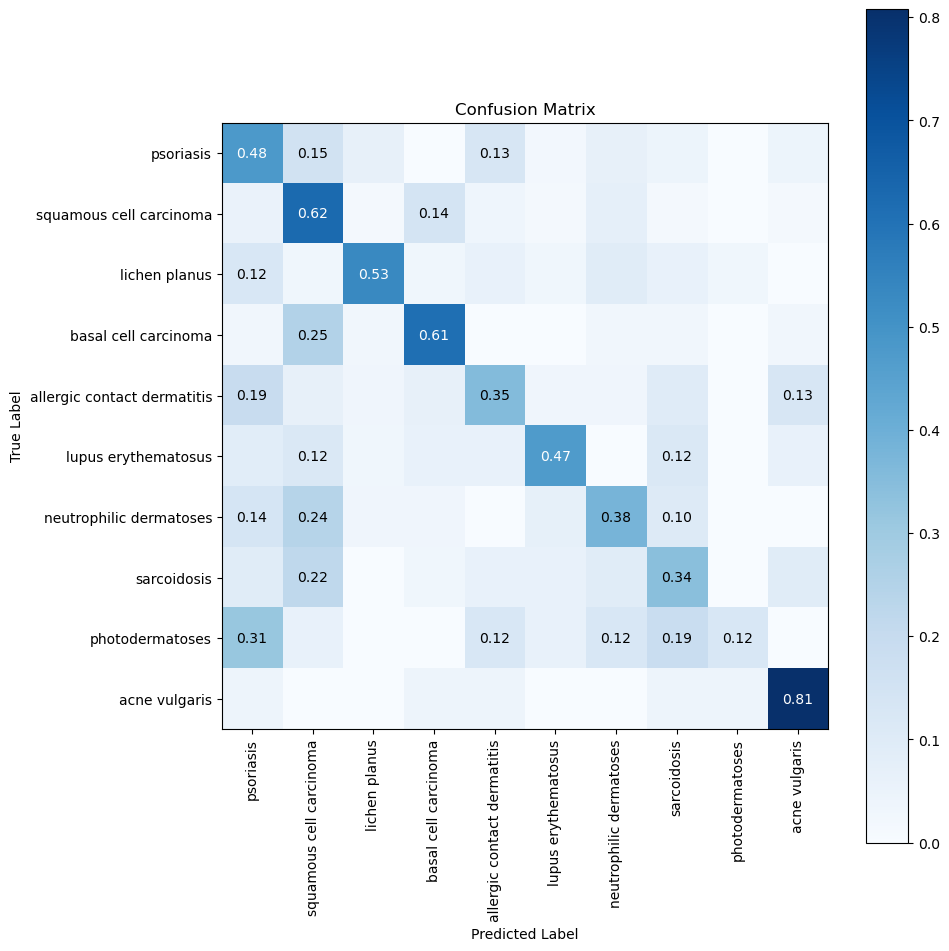

In [92]:
class_indices = test_generator.class_indices
swapped_class_indices = {value: key for key, value in class_indices.items()}

plot_heatmap_relevant_labels(y_true_model_model_custom_mod, y_pred_model_custom_mod, swapped_class_indices, top_n=10)

__model_a__

In [93]:
# weighted F1 score: 0.0581
y_true_model_model_a, y_pred_model_a = evaluate_model(model_a, test_generator)

Evaluating sequential...
78/78 [==============================] - 14s 170ms/step
sequential Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        27
           2       0.12      0.57      0.20        51
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        65
           7       0.17      0.09      0.12        11
           8       0.14      0.19      0.16        70
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00        12
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        10
          15       0

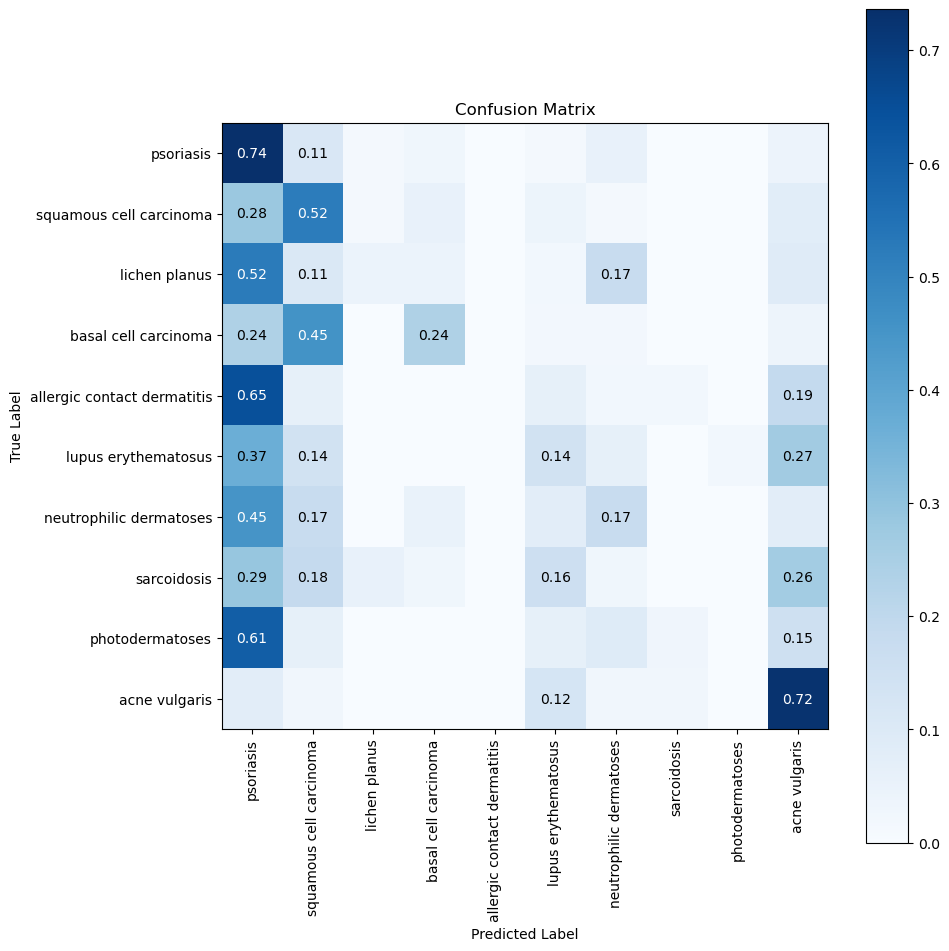

In [94]:
plot_heatmap_relevant_labels(y_true_model_model_a, y_pred_model_a, swapped_class_indices, top_n=10)

__model_b__

In [95]:
# weighted F1 score: 0.3607
y_true_model_model_b, y_pred_model_b = evaluate_model(model_b, test_generator)

Evaluating sequential_1...
78/78 [==============================] - 18s 230ms/step
sequential_1 Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.57      0.47        14
           1       0.24      0.33      0.28        27
           2       0.45      0.47      0.46        51
           3       0.22      0.20      0.21        10
           4       0.89      0.57      0.70        14
           5       0.30      0.27      0.29        26
           6       0.20      0.15      0.17        65
           7       0.42      0.45      0.43        11
           8       0.36      0.37      0.37        70
           9       0.46      0.60      0.52        10
          10       0.75      0.33      0.46         9
          11       0.44      0.44      0.44         9
          12       0.50      0.42      0.45        12
          13       0.62      0.50      0.55        16
          14       0.14      0.40      0.21        10
          15    

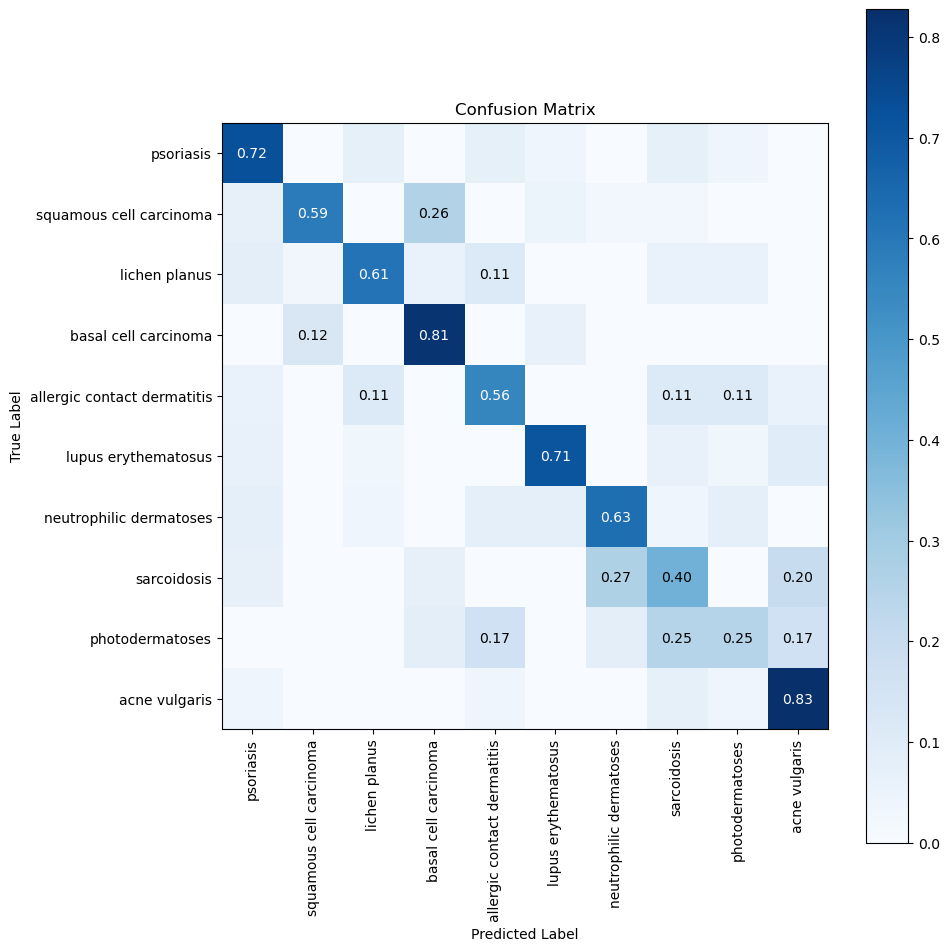

In [96]:
plot_heatmap_relevant_labels(y_true_model_model_b, y_pred_model_b, swapped_class_indices, top_n=10)

### 7.3 Plotting Training History

#### 7.3.1 Model Custom

(without weights)

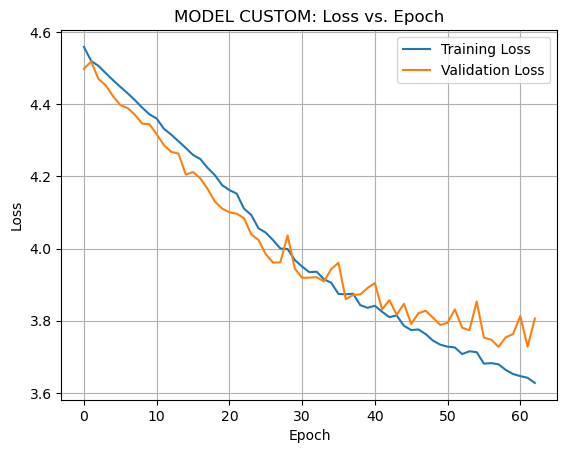

In [97]:
plot_history(history_custom, metric_name='loss', title='MODEL CUSTOM: Loss vs. Epoch')

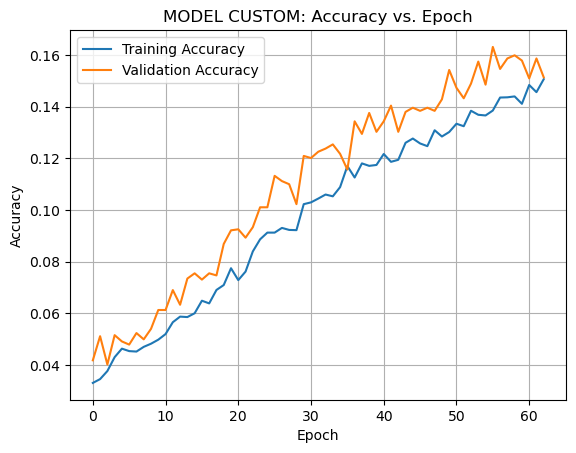

In [98]:
plot_history(history_custom, metric_name='accuracy', title='MODEL CUSTOM: Accuracy vs. Epoch')

Analyzing the accuracy history, it's evident that removing the class weights resulted in better regularization during training, instead of decreasing, the accuracy has shown improvement. However, the training accuracy appears to stabilize at a consistently low level, suggesting potential underfitting of the training data. This indicates that the model might be too simplistic for the task at hand, a consideration we'll take into account for future iterations.

(with weights)

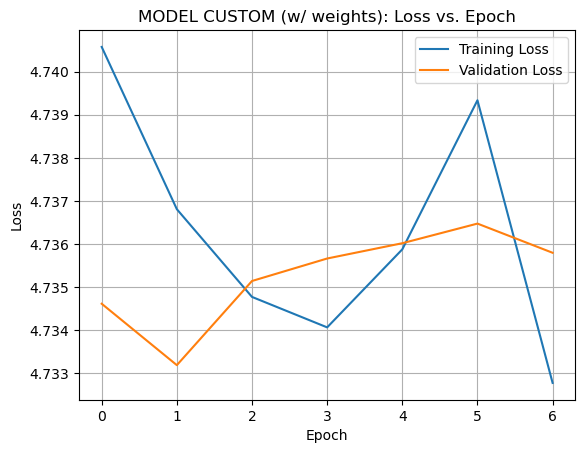

In [99]:
plot_history(history_custom_w_cw, metric_name='loss', title='MODEL CUSTOM (w/ weights): Loss vs. Epoch')

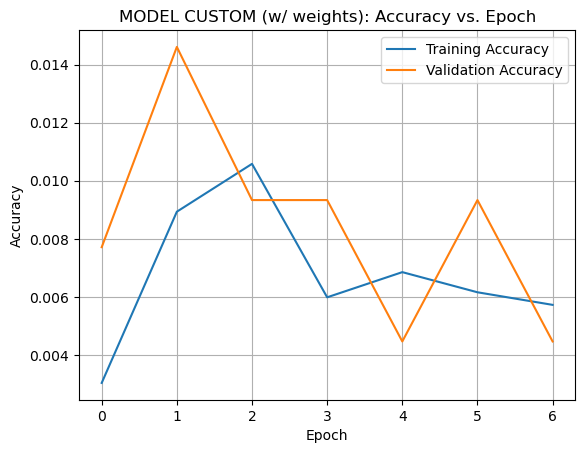

In [100]:
plot_history(history_custom_w_cw, metric_name='accuracy', title='MODEL CUSTOM (w/ weights): Accuracy vs. Epoch')

It's interesting to observe the contrasting behavior between these two models. The model trained with class weights exhibits a highly irregular training pattern in its loss values, whereas the model trained without class weights, while not optimal, demonstrates a more consistent and stable training trend.

#### 7.3.2 Model Transfer

(without weights)

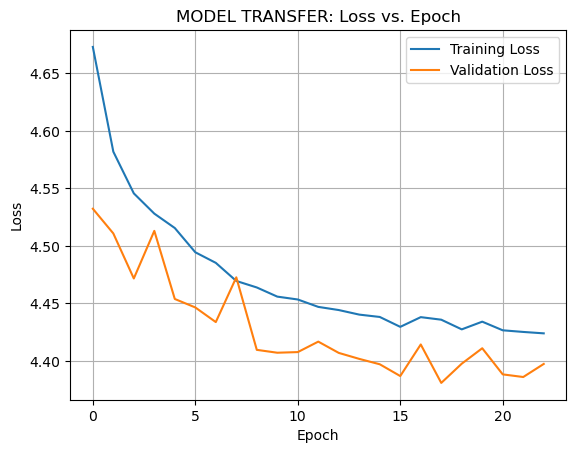

In [101]:
plot_history(history_transfer, metric_name='loss', title='MODEL TRANSFER: Loss vs. Epoch')

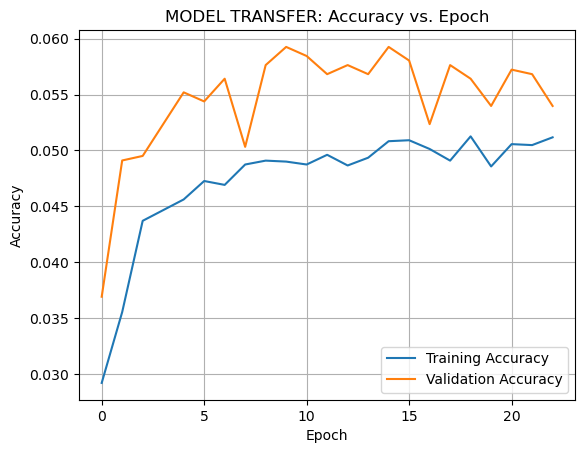

In [102]:
plot_history(history_transfer, metric_name='accuracy', title='MODEL TRANSFER: Accuracy vs. Epoch')

(with weights)

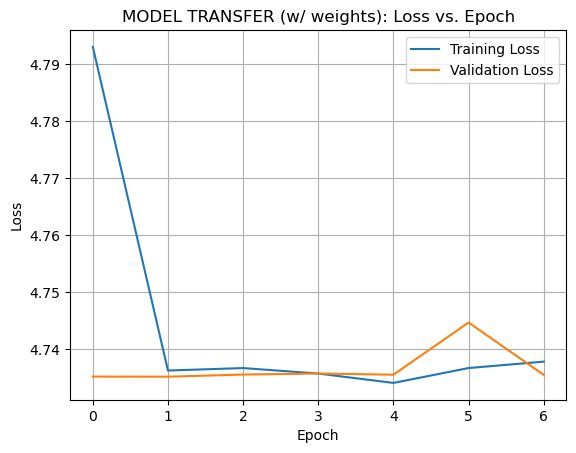

In [103]:
plot_history(history_transfer_w_cw, metric_name='loss', title='MODEL TRANSFER (w/ weights): Loss vs. Epoch')

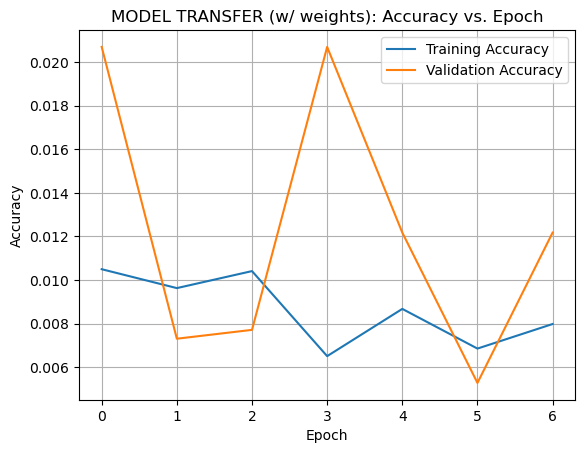

In [104]:
plot_history(history_transfer_w_cw, metric_name='accuracy', title='MODEL TRANSFER (w/ weights): Accuracy vs. Epoch')

#### 7.3.3 Model Transfer 2 Layers

(without weights)

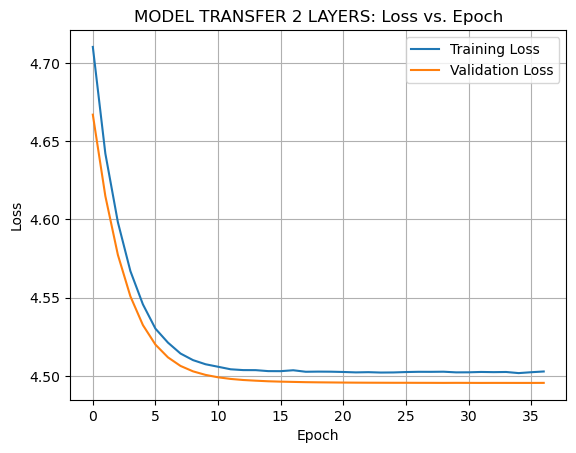

In [105]:
plot_history(history_transfer_2layers, metric_name='loss', title='MODEL TRANSFER 2 LAYERS: Loss vs. Epoch')

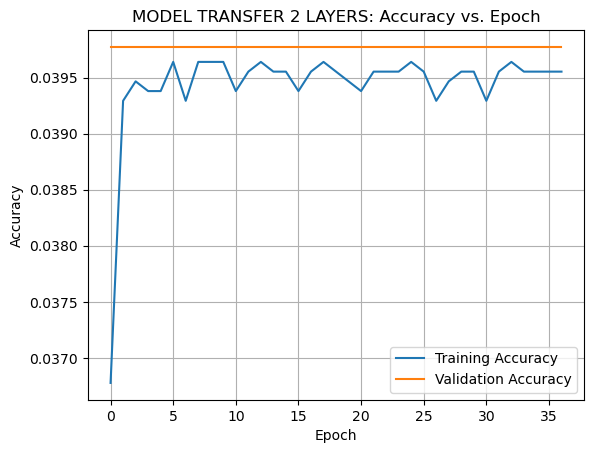

In [106]:
plot_history(history_transfer_2layers, metric_name='accuracy', title='MODEL TRANSFER 2 LAYERS: Accuracy vs. Epoch')

(with weights)

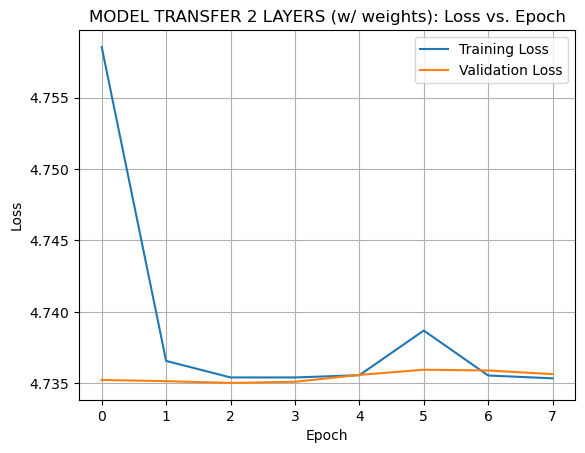

In [107]:
plot_history(history_transfer_2layers_w_cw, metric_name='loss', title='MODEL TRANSFER 2 LAYERS (w/ weights): Loss vs. Epoch')

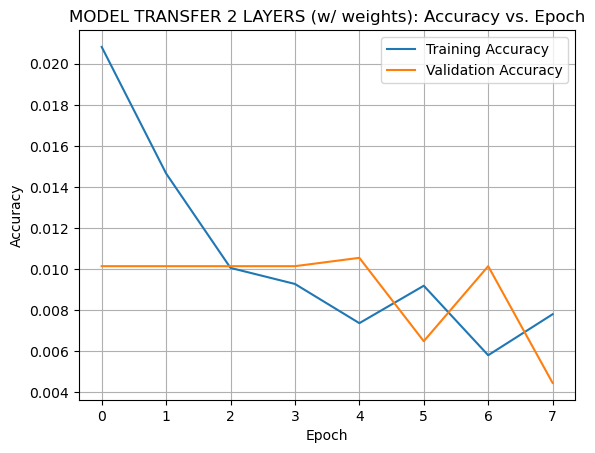

In [108]:
plot_history(history_transfer_2layers_w_cw, metric_name='accuracy', title='MODEL TRANSFER 2 LAYERS (w/ weights): Accuracy vs. Epoch')

#### 7.3.4 Model Custom Mod

The updated model iteration, which incorporates changes to address overfitting tendencies, appears to yield significantly improved results compared to the initial custom model iteration. Consequently, we will conduct a more detailed exploration of this model to investigate its performance on specific labels or categories.

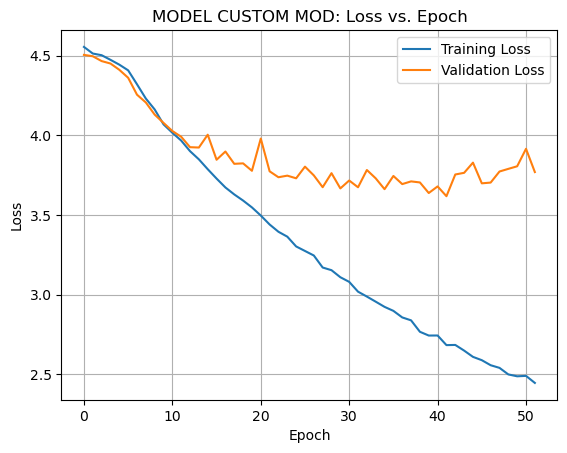

In [109]:
plot_history(history_custom_mod, metric_name='loss', title='MODEL CUSTOM MOD: Loss vs. Epoch')

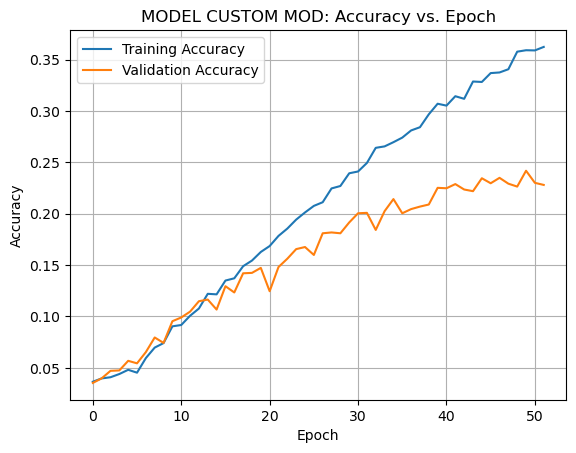

In [110]:
plot_history(history_custom_mod, metric_name='accuracy', title='MODEL CUSTOM MOD: Accuracy vs. Epoch')

#### 7.3.5 Model A

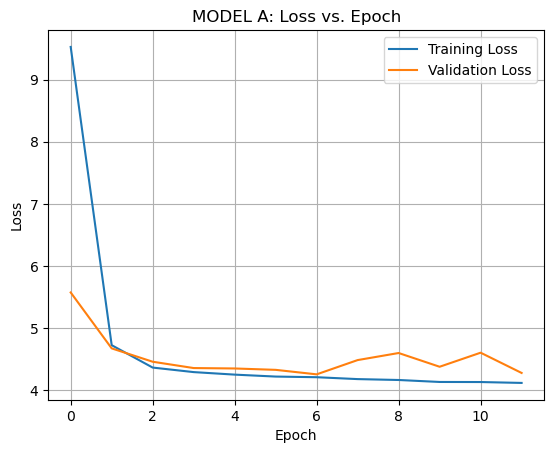

In [111]:
plot_history(history_model_a, metric_name='loss', title='MODEL A: Loss vs. Epoch')

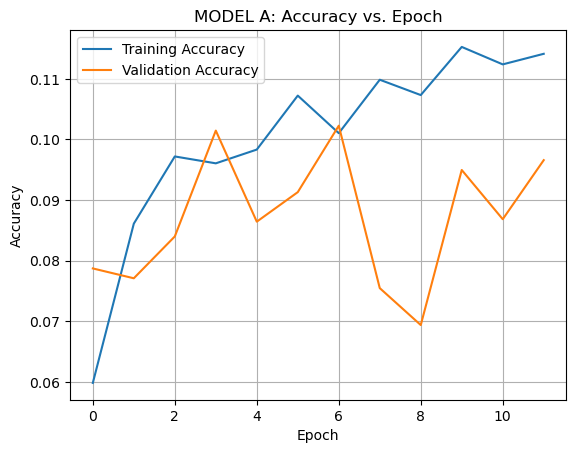

In [112]:
plot_history(history_model_a, metric_name='accuracy', title='MODEL A: Accuracy vs. Epoch')

#### 7.3.6 Model B

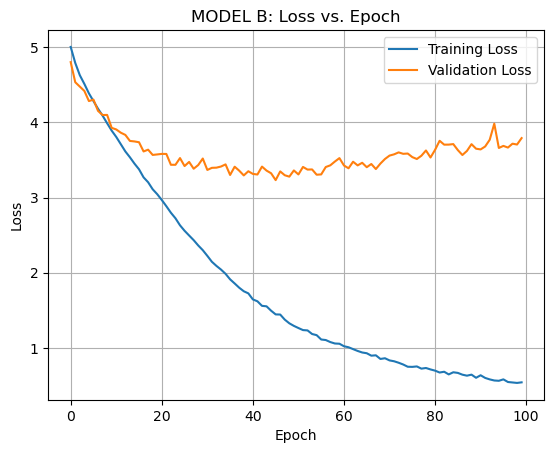

In [113]:
plot_history(history_model_b, metric_name='loss', title='MODEL B: Loss vs. Epoch')

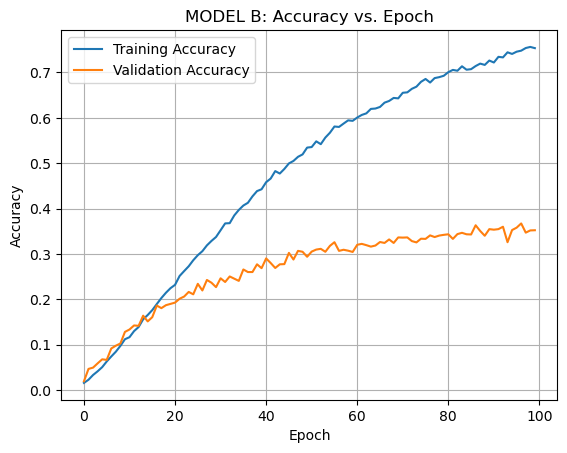

In [114]:
plot_history(history_model_b, metric_name='accuracy', title='MODEL B: Accuracy vs. Epoch')

# 8. Multi Input Model

### 8.1. Preprocessing non Images Data

In [115]:
train_df = X_train[["fitzpatrick_scale", "fitzpatrick_centaur", "nine_partition_label", "three_partition_label"]]
valid_df = X_val[["fitzpatrick_scale", "fitzpatrick_centaur", "nine_partition_label", "three_partition_label"]]
test_df = X_test[["fitzpatrick_scale", "fitzpatrick_centaur", "nine_partition_label", "three_partition_label"]]

In [116]:
def preprocess_labels(labels_series, label_encoder):
    # Encode labels using the provided label encoder
    labels_encoded = label_encoder.transform(labels_series)
    return labels_encoded

# Preprocess training data
train_labels_nine = train_df['nine_partition_label']
train_labels_three = train_df['three_partition_label']

# Fit label encoders on training labels
label_encoder_nine = LabelEncoder()
label_encoder_three = LabelEncoder()

label_encoder_nine.fit(train_labels_nine)
label_encoder_three.fit(train_labels_three)

# Encode training labels using the fitted label encoders
train_labels_nine_encoded = preprocess_labels(train_labels_nine, label_encoder_nine)
train_labels_three_encoded = preprocess_labels(train_labels_three, label_encoder_three)

# Update training DataFrame with preprocessed labels
train_df.loc[:, 'nine_partition_label'] = train_labels_nine_encoded
train_df.loc[:, 'three_partition_label'] = train_labels_three_encoded

# Preprocess validation data
valid_labels_nine = valid_df['nine_partition_label']
valid_labels_three = valid_df['three_partition_label']

# Encode validation labels using the label encoders from training
valid_labels_nine_encoded = preprocess_labels(valid_labels_nine, label_encoder_nine)
valid_labels_three_encoded = preprocess_labels(valid_labels_three, label_encoder_three)

# Update validation DataFrame with preprocessed labels
valid_df.loc[:, 'nine_partition_label'] = valid_labels_nine_encoded
valid_df.loc[:, 'three_partition_label'] = valid_labels_three_encoded

# Preprocess test data
test_labels_nine = test_df['nine_partition_label']
test_labels_three = test_df['three_partition_label']

# Encode test labels using the label encoders from training
test_labels_nine_encoded = preprocess_labels(test_labels_nine, label_encoder_nine)
test_labels_three_encoded = preprocess_labels(test_labels_three, label_encoder_three)

# Update test DataFrame with preprocessed labels
test_df.loc[:, 'nine_partition_label'] = test_labels_nine_encoded
test_df.loc[:, 'three_partition_label'] = test_labels_three_encoded

In [117]:
train_df.head()

,fitzpatrick_scale,fitzpatrick_centaur,nine_partition_label,three_partition_label
1008,4,4,4,2
11509,2,1,4,2
2054,2,2,4,2
16403,4,3,4,2
12686,3,1,4,2


In [118]:
valid_df.head()

,fitzpatrick_scale,fitzpatrick_centaur,nine_partition_label,three_partition_label
203,3,3,8,1
11414,2,1,0,0
15506,3,3,4,2
7738,4,3,4,2
9019,3,3,4,2


In [119]:
test_df.head()

,fitzpatrick_scale,fitzpatrick_centaur,nine_partition_label,three_partition_label
14171,3,4,0,0
10904,1,1,4,2
51,2,1,7,1
12443,4,3,3,2
12406,3,3,4,2


### 8.2. Builiding and Training the Multi Input Model

In [120]:
multi_input_model, multi_input_history = load_model_history('models/multi_input_model')

__BUILDING__

In [121]:
# def build_multi_input_model(pretrained_model, num_features, num_classes):
#     """
#     Constructs a sequential-like multi-input model by creating a functional model that behaves as a sequential model.
#     This setup uses a pre-trained CNN for image feature extraction combined with additional non-image data inputs.
# 
#     Args:
#         pretrained_model (tensorflow.keras.Model): A pre-trained model for image feature extraction.
#         num_features (int): Number of features in the non-image data input.
#         num_classes (int): Number of output classes for classification.
# 
#     Returns:
#         tensorflow.keras.Model: A compiled model that internally handles multiple inputs but is used like a sequential model.
#     """
#     pretrained_model.trainable = False
#     
#     # Image input and processing
#     image_input = Input(shape=(224, 224, 3), name='image_input')
#     image_features = pretrained_model(image_input)
#     image_features = Flatten()(image_features)  # Flatten the output from the pre-trained model
# 
#     # Non-image input
#     non_image_input = Input(shape=(num_features,), name='non_image_input')
# 
#     # Concatenate image features and non-image input
#     combined_features = concatenate([image_features, non_image_input])
# 
#     # Using Sequential API to define further layers
#     top_model = Sequential([
#         Dense(128, activation='relu'),
#         Dense(num_classes, activation='softmax')
#     ], name='top_model')
# 
#     # Get the output through the top_model
#     outputs = top_model(combined_features)
# 
#     # Create the complete model
#     multi_input_model = Model(inputs=[image_input, non_image_input], outputs=outputs)
# 
#     return multi_input_model
# 
# # Instantiate and compile the multi-input model
# multi_input_model = build_multi_input_model(model_b, num_features=4, num_classes=114)
# 
# # Compile the model
# multi_input_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

__MULTI-INPUT GENERATORS__

In [122]:
def extract_number_from_filename(filename):
    # Use regular expression to extract numbers from the filename
    numbers = re.findall(r'\d+', filename)
    
    if numbers:
        # Extract the first number found and convert it to an integer
        extracted_number = int(numbers[0])
        return extracted_number
    else:
        # Return None if no number is found in the filename
        return None

Creating a multi-input generator object where we add tabular data to the image batch generated from the image generator so we can generate a multi input generator to pass the data to the model in the right structure

In [123]:
class MultiInputGenerator(Sequence):
    """
    A custom generator class for Keras models that require multiple inputs.

    This generator wraps around a standard image generator and pairs the image data with additional metadata 
    for each batch, allowing models to train on image and non-image data simultaneously.

    Attributes:
        image_generator (Iterator): A generator or an instance of `ImageDataGenerator` that yields batches of image data and labels.
        metadata_df (pandas.DataFrame): A DataFrame containing the metadata associated with each image.
        batch_size (int): The size of the batches to produce.
        classes (numpy.array): An array of class labels for each image in the generator. This attribute is extracted from the
                               `image_generator` and is used to provide labels for computing metrics and evaluating the model.

    Methods:
        __len__(): Returns the number of batches per epoch.
        __getitem__(idx): Returns a batch at a given index.
    """
    def __init__(self, image_generator, metadata_df, batch_size):
        """
        Initializes the MultiInputGenerator with an image generator, a metadata DataFrame, and a batch size.

        Args:
            image_generator (Iterator): The generator yielding batches of image data.
            metadata_df (pandas.DataFrame): A DataFrame containing metadata corresponding to each image.
            batch_size (int): The number of images per batch.
        """
        self.image_generator = image_generator
        self.metadata_df = metadata_df
        self.batch_size = batch_size
        self.classes = image_generator.classes

    def __len__(self):
        """
        Determine the number of batches per epoch.

        Returns:
            int: The total number of batches in the image_generator.
        """
        return len(self.image_generator)
    
    def reset(self):
        """Resets the generator to the start of the data."""
        self.image_generator.reset()

    def __getitem__(self, idx):
        """
        Retrieve a batch with the given index, combining image data and metadata into a multi-input format.

        Args:
            idx (int): Index of the batch to retrieve.

        Returns:
            tuple: A tuple where the first element is a list containing numpy arrays of image data and corresponding metadata,
                   and the second element is a numpy array of labels.
        """
        image_batch, label_batch = self.image_generator[idx]
        data_batch = []

        for i in range(len(image_batch)):
            filename = self.image_generator.filenames[idx * self.batch_size + i]
            index = extract_number_from_filename(filename)
            info = self.metadata_df.iloc[index]
            metadata = [info["fitzpatrick_scale"], info["fitzpatrick_centaur"],info["nine_partition_label"], info["three_partition_label"]]
            data_batch.append(metadata)

        return [np.array(image_batch), np.array(data_batch)], np.array(label_batch)

In [124]:
train_generator_multi = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 11561 images belonging to 114 classes.


In [125]:
train_multi_generator = MultiInputGenerator(train_generator_multi, train_df, 32)
val_multi_generator = MultiInputGenerator(val_generator, valid_df, 32)
test_multi_generator = MultiInputGenerator(test_generator, test_df, 32)

__CALLBACKS__

In [126]:
# callbacks_multi = [
#     ModelCheckpoint(
#         'model_multi.keras', 
#         monitor='val_loss', 
#         save_best_only=True, 
#         verbose=1
#     ),
#     EarlyStopping(
#         monitor='val_loss', 
#         patience=5, 
#         verbose=1,
#         restore_best_weights=True
#     ) 
# ]

__TRAINING__

In [127]:
# multi_input_history=multi_input_model.fit(train_multi_generator, 
#                                           epochs=100, 
#                                           validation_data=val_multi_generator, 
#                                           callbacks=callbacks_multi)

__SAVING__

In [128]:
# save_model_history(multi_input_model, multi_input_history, 'multi_input_model')

__EVALUATING__

In [129]:
# weighted F1 score: 0.4067
y_true_model_multi_input_model, y_pred_multi_input_model = evaluate_model(multi_input_model, test_multi_generator)

Evaluating model_1...
78/78 [==============================] - 19s 223ms/step
model_1 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.57      0.59        14
           1       0.27      0.11      0.16        27
           2       0.40      0.57      0.47        51
           3       0.50      0.20      0.29        10
           4       1.00      0.57      0.73        14
           5       0.54      0.27      0.36        26
           6       0.14      0.38      0.20        65
           7       0.57      0.36      0.44        11
           8       0.39      0.47      0.43        70
           9       0.62      0.50      0.56        10
          10       0.16      0.33      0.21         9
          11       1.00      0.44      0.62         9
          12       0.57      0.33      0.42        12
          13       0.80      0.50      0.62        16
          14       0.29      0.40      0.33        10
          15       0.56   

# 9. Model Comparisons

Exploring the labels with worse performance "pilomatricoma"

In [130]:
y_train[y_train == "pilomatricoma"].shape

(37,)

In [131]:
y_train.value_counts()

label
psoriasis                      457
squamous cell carcinoma        407
lichen planus                  344
basal cell carcinoma           328
allergic contact dermatitis    301
                              ... 
paronychia                      41
erythema elevatum diutinum      39
xanthomas                       37
pustular psoriasis              37
pilomatricoma                   37
Name: count, Length: 114, dtype: int64

In [132]:
y_true_model_model_b[y_true_model_model_b == 77]

array([77, 77, 77, 77, 77, 77, 77, 77])

In [133]:
predicted_labels_instead = y_pred_model_b[y_true_model_model_b == 77]
predicted_labels_instead

array([98, 54, 56, 93, 14, 91, 53, 98], dtype=int64)

In [134]:
predicted_labels_instead_2 = [swapped_class_indices[label] for label in predicted_labels_instead]
predicted_labels_instead_2

['squamous cell carcinoma',
 'lymphangioma',
 'melanoma',
 'scleroderma',
 'congenital nevus',
 'sarcoidosis',
 'lyme disease',
 'squamous cell carcinoma']

Training curves (model_custom_mod VS model_b)

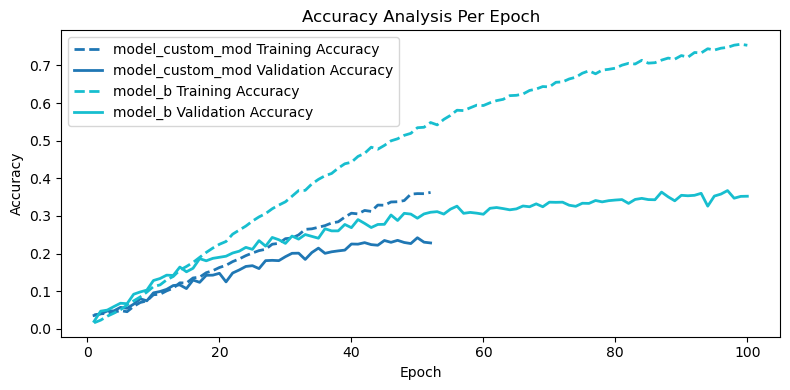

In [135]:
plot_accuracy_trends([history_custom_mod, history_model_b],
                    ["model_custom_mod", "model_b"])

F1 score distribuition (model_custom_mod VS model_b)

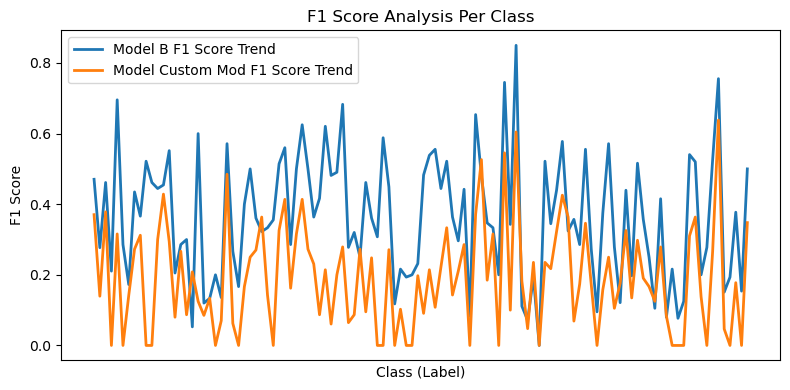

In [136]:
analyze_model_f1_score([y_true_model_model_b, y_true_model_model_custom_mod], 
                       [y_pred_model_b, y_pred_model_custom_mod],
                      ["Model B", "Model Custom Mod"])

F1 score and the training set representation

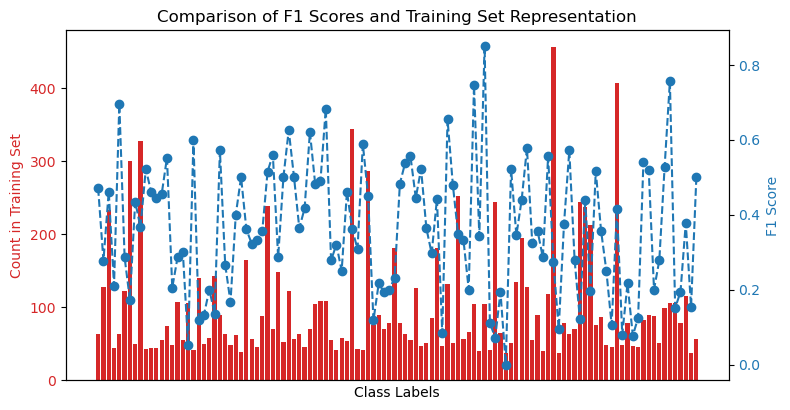

In [137]:
compare_f1_and_representation(y_true_model_model_b, y_pred_model_b, train_generator)

Class prediction breakdown for the model_b and multi_input_model

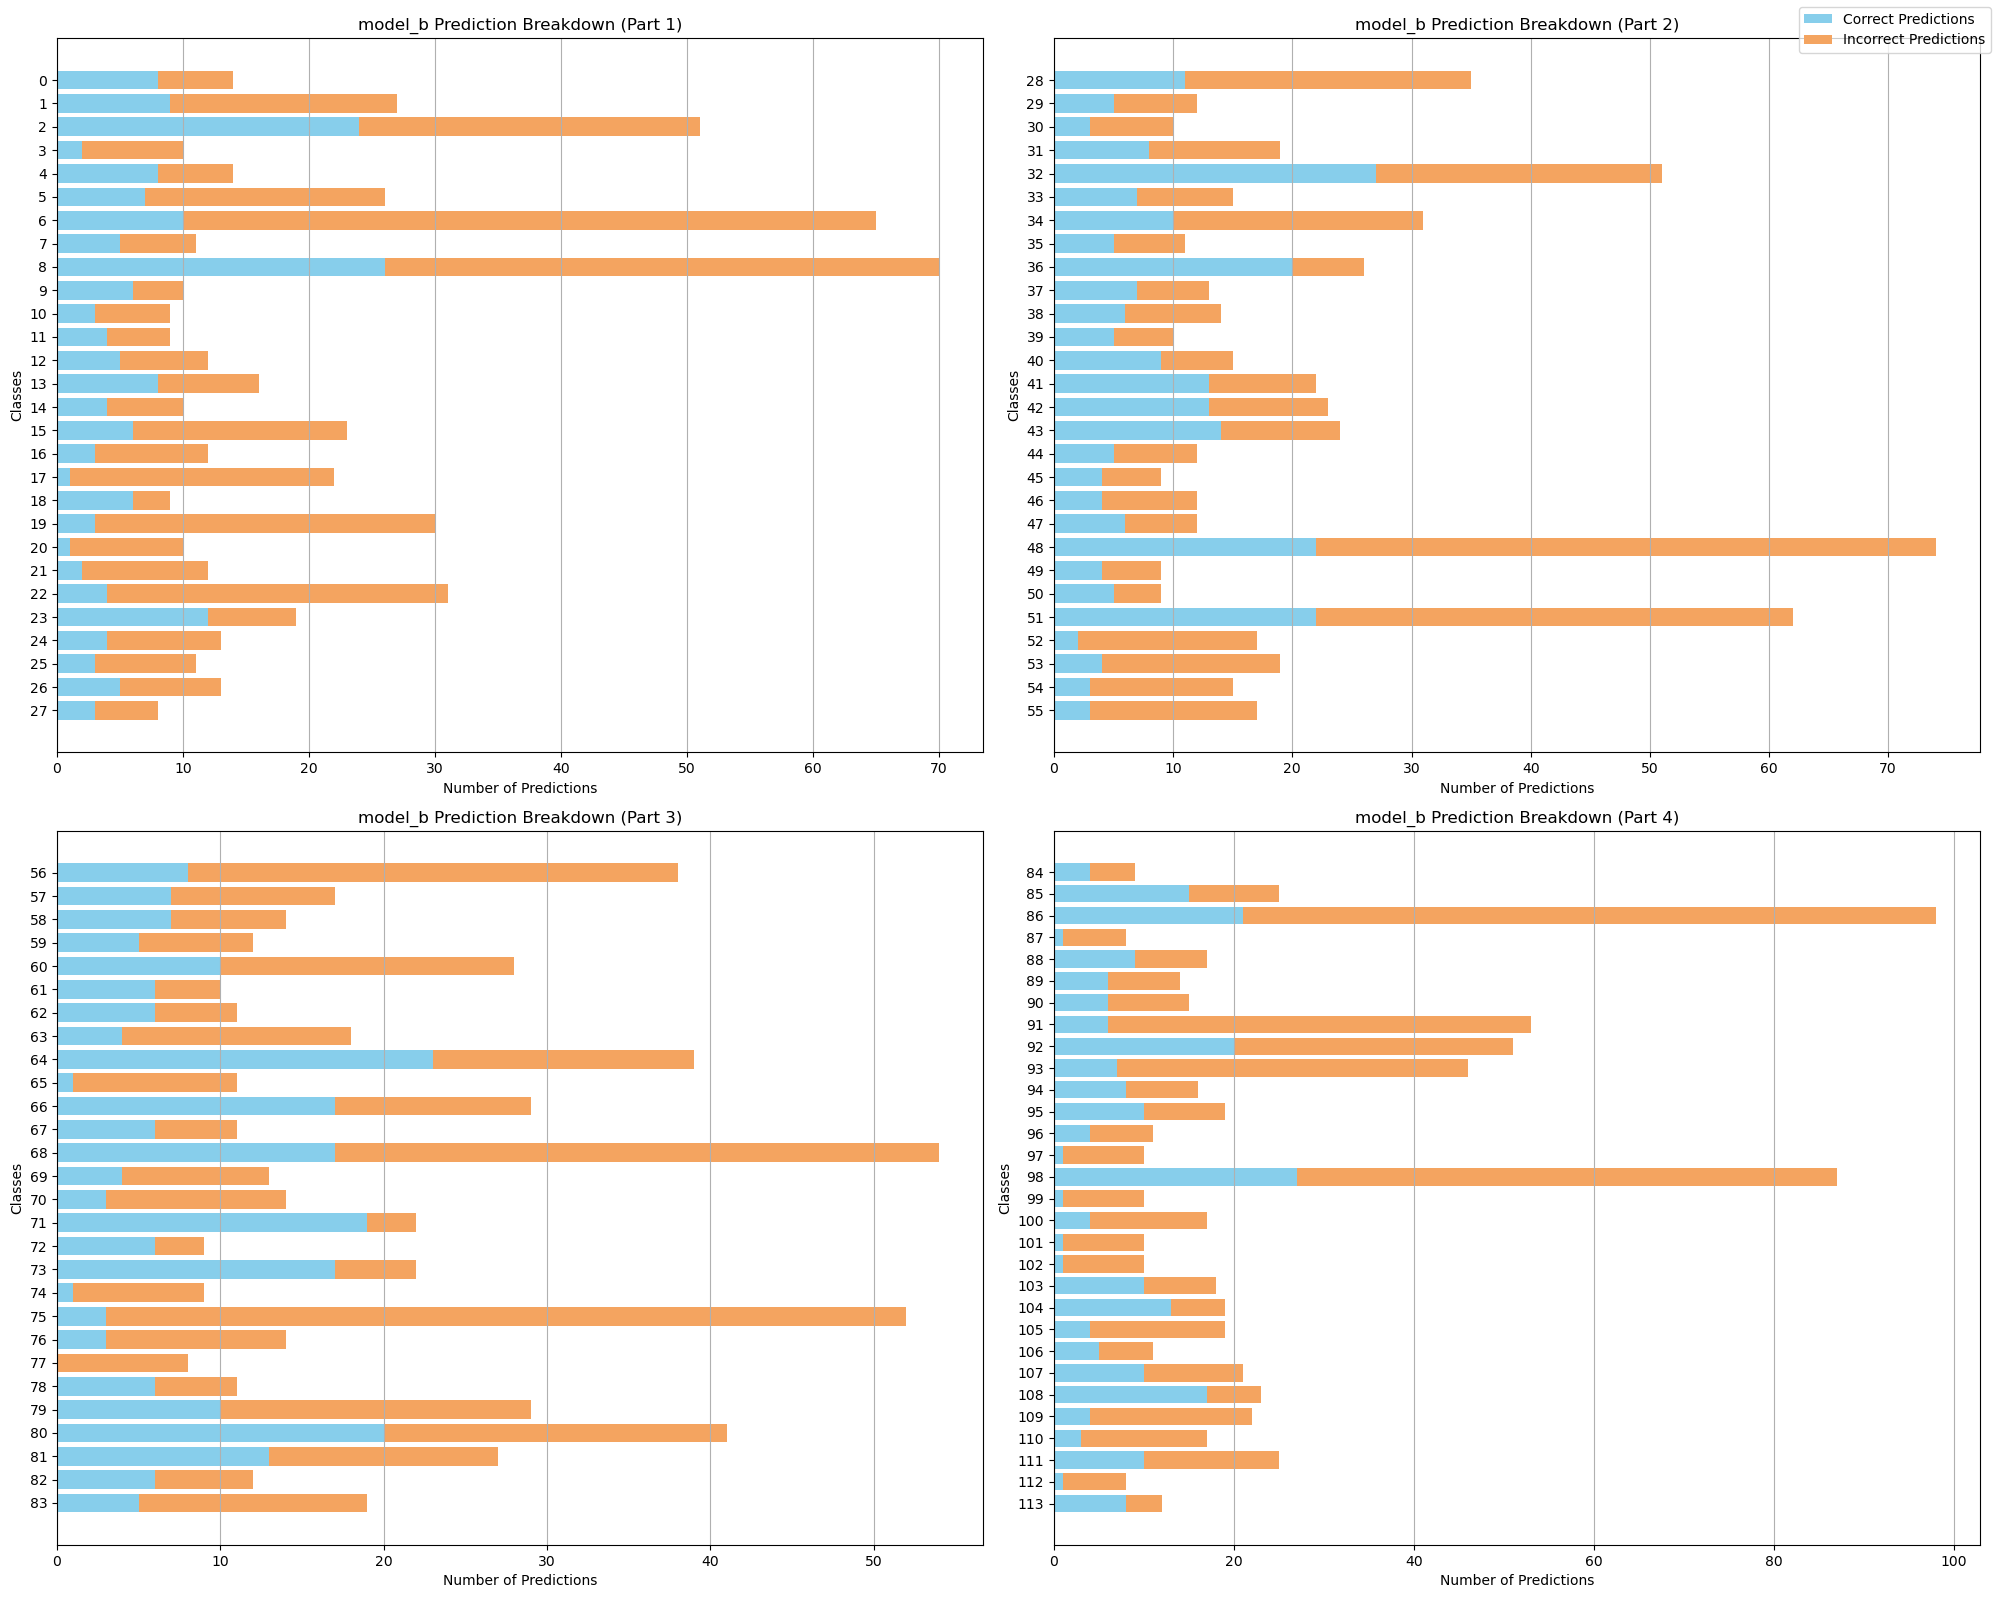

In [138]:
plot_class_prediction_breakdown(y_true_model_model_b, y_pred_model_b, model_name='model_b')

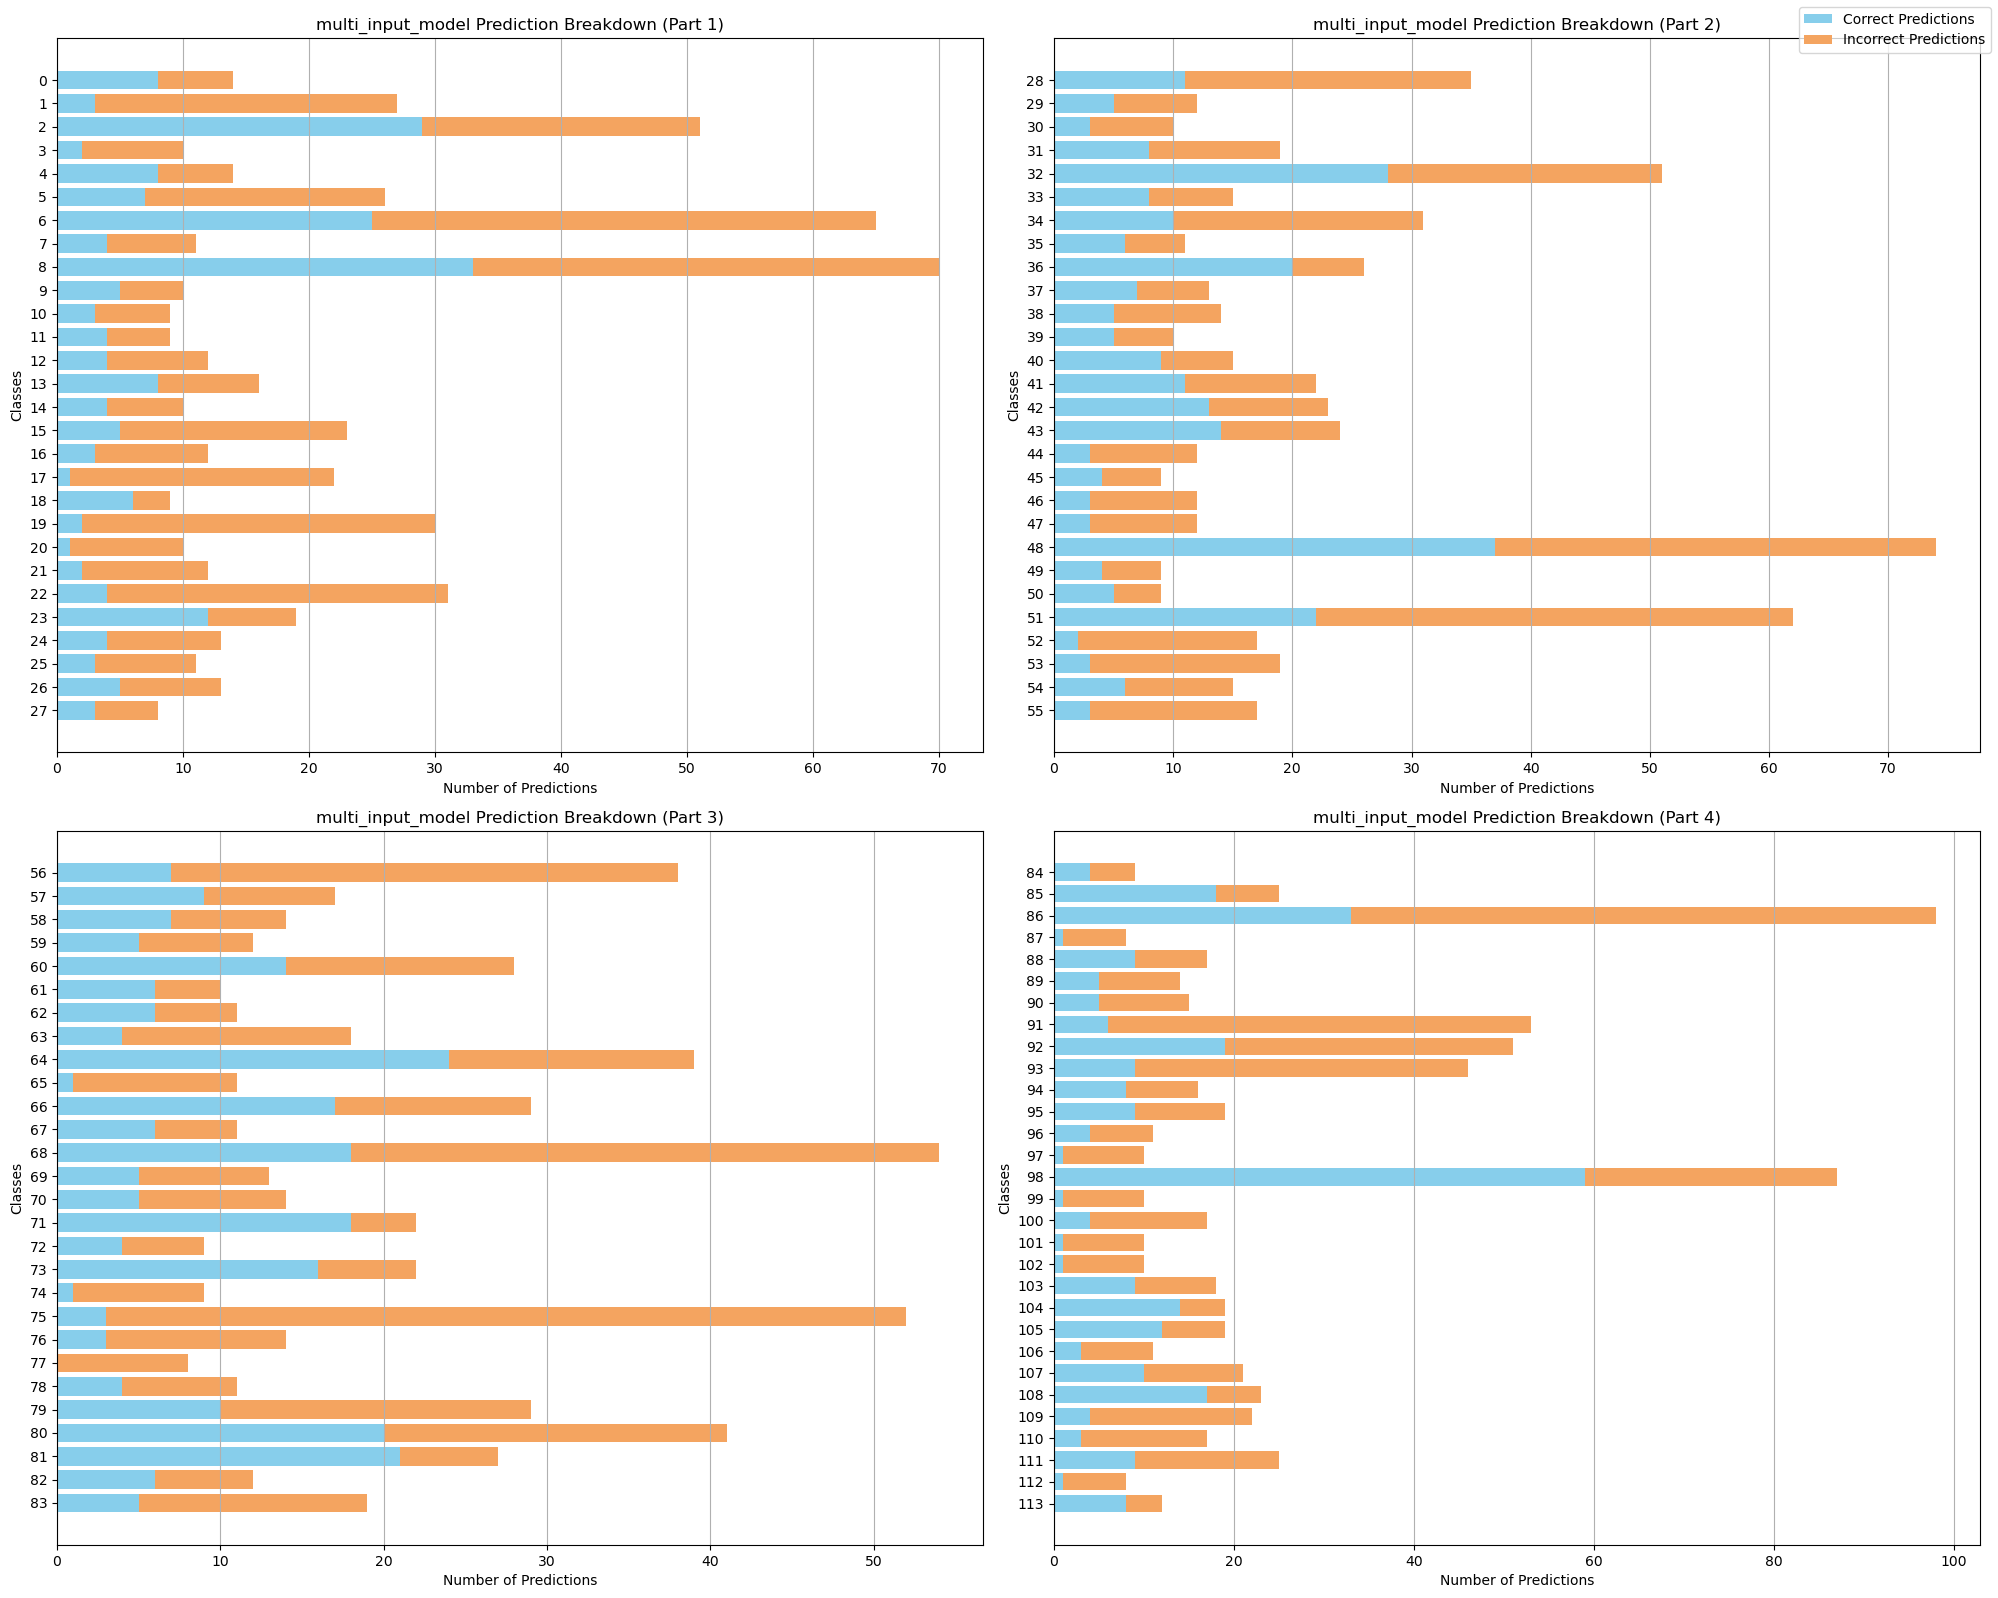

In [139]:
plot_class_prediction_breakdown(y_true_model_multi_input_model, y_pred_multi_input_model, model_name='multi_input_model')

In [140]:
swapped_class_indices

{0: 'acanthosis nigricans',
 1: 'acne',
 2: 'acne vulgaris',
 3: 'acquired autoimmune bullous diseaseherpes gestationis',
 4: 'acrodermatitis enteropathica',
 5: 'actinic keratosis',
 6: 'allergic contact dermatitis',
 7: 'aplasia cutis',
 8: 'basal cell carcinoma',
 9: 'basal cell carcinoma morpheiform',
 10: 'becker nevus',
 11: 'behcets disease',
 12: 'calcinosis cutis',
 13: 'cheilitis',
 14: 'congenital nevus',
 15: 'dariers disease',
 16: 'dermatofibroma',
 17: 'dermatomyositis',
 18: 'disseminated actinic porokeratosis',
 19: 'drug eruption',
 20: 'drug induced pigmentary changes',
 21: 'dyshidrotic eczema',
 22: 'eczema',
 23: 'ehlers danlos syndrome',
 24: 'epidermal nevus',
 25: 'epidermolysis bullosa',
 26: 'erythema annulare centrifigum',
 27: 'erythema elevatum diutinum',
 28: 'erythema multiforme',
 29: 'erythema nodosum',
 30: 'factitial dermatitis',
 31: 'fixed eruptions',
 32: 'folliculitis',
 33: 'fordyce spots',
 34: 'granuloma annulare',
 35: 'granuloma pyogenic',
 